In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pyspark


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1=pd.read_csv('/content/drive/MyDrive/Project4/Load_data/20020101pal_csv/20020101pal.csv')
df1

,Time Stamp,Time Zone,Name,PTID,Load
0,01/01/2002 00:00:00,EST,CAPITL,61757.0,1250
1,01/01/2002 00:00:00,EST,CENTRL,61754.0,1833
2,01/01/2002 00:00:00,EST,DUNWOD,61760.0,544
3,01/01/2002 00:00:00,EST,GENESE,61753.0,1056
4,01/01/2002 00:00:00,EST,HUD VL,61758.0,1248
...,...,...,...,...,...
2835,01/01/2002 23:55:13,EST,MHK VL,61756.0,764
2836,01/01/2002 23:55:13,EST,MILLWD,61759.0,234
2837,01/01/2002 23:55:13,EST,N.Y.C._LONGIL,NaN,6975
2838,01/01/2002 23:55:13,EST,NORTH,61755.0,790


In [ ]:
df2=pd.read_csv('/content/drive/MyDrive/Project4/Load_data/20020101pal_csv/20020102pal.csv')
df2

,Time Stamp,Time Zone,Name,PTID,Load
0,01/02/2002 00:00:00,EST,CAPITL,61757.0,1189
1,01/02/2002 00:00:00,EST,CENTRL,61754.0,1618
2,01/02/2002 00:00:00,EST,DUNWOD,61760.0,446
3,01/02/2002 00:00:00,EST,GENESE,61753.0,971
4,01/02/2002 00:00:00,EST,HUD VL,61758.0,1086
...,...,...,...,...,...
3995,01/02/2002 23:56:10,EST,MHK VL,61756.0,783
3996,01/02/2002 23:56:10,EST,MILLWD,61759.0,225
3997,01/02/2002 23:56:10,EST,N.Y.C._LONGIL,NaN,6976
3998,01/02/2002 23:56:10,EST,NORTH,61755.0,752


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import pandas as pd


In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("NYISO Data Processing") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [ ]:
load_data_path = "/content/drive/MyDrive/Project4/Load_data"  # Update with the actual GDrive path
pricing_data_path = "/content/drive/MyDrive/Project4/Pricing_data"


In [ ]:
# Schema for Load_data and Pricing_data
load_schema = StructType([
    StructField("timestamp", StringType(), True),
    StructField("PTID", IntegerType(), True),
    StructField("Integrated_Load", FloatType(), True)
])

pricing_schema = StructType([
    StructField("timestamp", StringType(), True),
    StructField("PTID", IntegerType(), True),
    StructField("LBMP", FloatType(), True),
    StructField("Marginal_Cost_Loss", FloatType(), True),
    StructField("Marginal_Cost_Congestion", FloatType(), True)
])

# Load data as streaming DataFrames
load_streaming_df = spark.readStream.schema(load_schema).csv(load_data_path)
pricing_streaming_df = spark.readStream.schema(pricing_schema).csv(pricing_data_path)


In [ ]:
# Synchronize on the 'timestamp' and 'PTID' columns
synchronized_df = load_streaming_df.join(pricing_streaming_df, ["timestamp", "PTID"])

# Output merged stream to memory for processing
query = synchronized_df.writeStream.format("memory").queryName("synchronized_data").start()


In [ ]:
import os

# Check the contents of Load_data directory
load_data_path = "/content/drive/MyDrive/Project4/Load_data"
print("Files in Load_data directory:")
print(os.listdir(load_data_path))

# Check the contents of Pricing_data directory
pricing_data_path = "/content/drive/MyDrive/Project4/Pricing_data"
print("Files in Pricing_data directory:")
print(os.listdir(pricing_data_path))


Files in Load_data directory:
['20020401pal_csv', '20020801pal_csv', '20020201pal_csv', '20020701pal_csv', '20020101pal_csv', '20020301pal_csv', '20020501pal_csv', '20021201pal_csv', '20020601pal_csv', '20020901pal_csv', '20021001pal_csv', '20021101pal_csv']
Files in Pricing_data directory:
['20020101realtime_zone_csv', '20020501realtime_zone_csv', '20021101realtime_zone_csv', '20020701realtime_zone_csv', '20020401realtime_zone_csv', '20021001realtime_zone_csv', '20020901realtime_zone_csv', '20020601realtime_zone_csv', '20021201realtime_zone_csv', '20020801realtime_zone_csv', '20020301realtime_zone_csv', '20020201realtime_zone_csv']


# **Data Loading**

In [ ]:
# Update paths to include all subdirectories
load_data_path = "/content/drive/MyDrive/Project4/Load_data/*/*"
pricing_data_path = "/content/drive/MyDrive/Project4/Pricing_data/*/*"

# Reload the data
load_data = spark.read.option("header", True).csv(load_data_path)
pricing_data = spark.read.option("header", True).csv(pricing_data_path)

# Verify the loaded data
print("Load_data row count:", load_data.count())
print("Pricing_data row count:", pricing_data.count())
load_data.show(5)
pricing_data.show(5)


Load_data row count: 1399360
Pricing_data row count: 2101470
+-------------------+---------+------+-----+----+
|         Time Stamp|Time Zone|  Name| PTID|Load|
+-------------------+---------+------+-----+----+
|08/05/2002 00:00:00|      EDT|CAPITL|61757|1480|
|08/05/2002 00:00:00|      EDT|CENTRL|61754|1814|
|08/05/2002 00:00:00|      EDT|DUNWOD|61760| 910|
|08/05/2002 00:00:00|      EDT|GENESE|61753|1135|
|08/05/2002 00:00:00|      EDT|HUD VL|61758|1417|
+-------------------+---------+------+-----+----+
only showing top 5 rows

+-------------------+------+-----+-------------+-----------------------------+---------------------------------+
|         Time Stamp|  Name| PTID|LBMP ($/MWHr)|Marginal Cost Losses ($/MWHr)|Marginal Cost Congestion ($/MWHr)|
+-------------------+------+-----+-------------+-----------------------------+---------------------------------+
|08/05/2002 00:00:00|CAPITL|61757|        37.29|                         1.31|                             0.00|
|08/05/2002 

In [ ]:
# Check for null or missing values in Load_data
print("Null values in Load_data:")
load_data.select([col(c).isNull().alias(c + "_isnull") for c in load_data.columns]).show()

# Check for null or missing values in Pricing_data
print("Null values in Pricing_data:")
pricing_data.select([col(c).isNull().alias(c + "_isnull") for c in pricing_data.columns]).show()


Null values in Load_data:
+-----------------+----------------+-----------+-----------+-----------+
|Time Stamp_isnull|Time Zone_isnull|Name_isnull|PTID_isnull|Load_isnull|
+-----------------+----------------+-----------+-----------+-----------+
|            false|           false|      false|      false|      false|
|            false|           false|      false|      false|      false|
|            false|           false|      false|      false|      false|
|            false|           false|      false|      false|      false|
|            false|           false|      false|      false|      false|
|            false|           false|      false|      false|      false|
|            false|           false|      false|      false|      false|
|            false|           false|      false|       true|      false|
|            false|           false|      false|      false|      false|
|            false|           false|      false|      false|      false|
|            false|      

In [ ]:
# Summary statistics for Load_data
print("Summary statistics for Load_data:")
load_data.describe().show()

# Summary statistics for Pricing_data
print("Summary statistics for Pricing_data:")
pricing_data.describe().show()


Summary statistics for Load_data:
+-------+-------------------+---------+-------+-----------------+------------------+
|summary|         Time Stamp|Time Zone|   Name|             PTID|              Load|
+-------+-------------------+---------+-------+-----------------+------------------+
|  count|            1399360|  1399360|1399360|          1259424|           1399360|
|   mean|               NULL|     NULL|   NULL|          61756.0|1817.3563564772467|
| stddev|               NULL|     NULL|   NULL|2.581989922539562| 2325.798939316026|
|    min|01/01/2002 00:00:00|      EDT| CAPITL|            61752|                -1|
|    max|12/31/2002 23:55:21|      EST|   WEST|            61760|              9999|
+-------+-------------------+---------+-------+-----------------+------------------+

Summary statistics for Pricing_data:
+-------+-------------------+-------+------------------+------------------+-----------------------------+---------------------------------+
|summary|         Time 

# **Merging Data Sets and Visualizations**

In [ ]:
# Print column names for Load_data
print("Load_data columns:", load_data.columns)

# Print column names for Pricing_data
print("Pricing_data columns:", pricing_data.columns)


Load_data columns: ['Time Stamp', 'Time Zone', 'Name', 'PTID', 'Load']
Pricing_data columns: ['Time Stamp', 'Name', 'PTID', 'LBMP ($/MWHr)', 'Marginal Cost Losses ($/MWHr)', 'Marginal Cost Congestion ($/MWHr)']


In [ ]:
load_data = load_data.withColumnRenamed("Time Stamp", "timestamp") \
                     .withColumnRenamed("PTID", "PTID") \
                     .withColumnRenamed("Load", "Integrated_Load")


In [ ]:
pricing_data = pricing_data.withColumnRenamed("Time Stamp", "timestamp") \
                           .withColumnRenamed("PTID", "PTID") \
                           .withColumnRenamed("LBMP", "LBMP") \
                           .withColumnRenamed("Marginal Cost Loss", "Marginal_Cost_Loss") \
                           .withColumnRenamed("Marginal Cost Congestion", "Marginal_Cost_Congestion")


In [ ]:
print("Renamed Load_data columns:", load_data.columns)
print("Renamed Pricing_data columns:", pricing_data.columns)


Renamed Load_data columns: ['timestamp', 'Time Zone', 'Name', 'PTID', 'Integrated_Load']
Renamed Pricing_data columns: ['timestamp', 'Name', 'PTID', 'LBMP ($/MWHr)', 'Marginal Cost Losses ($/MWHr)', 'Marginal Cost Congestion ($/MWHr)']


In [ ]:
pricing_data = pricing_data.withColumnRenamed("LBMP ($/MWHr)", "LBMP") \
                           .withColumnRenamed("Marginal Cost Losses ($/MWHr)", "Marginal_Cost_Loss") \
                           .withColumnRenamed("Marginal Cost Congestion ($/MWHr)", "Marginal_Cost_Congestion") \
                           .withColumnRenamed("Time Stamp", "timestamp")


In [ ]:
load_data = load_data.withColumnRenamed("Time Stamp", "timestamp") \
                     .withColumnRenamed("Load", "Integrated_Load")


In [ ]:
# Cast column data types
load_data = load_data.withColumn("Integrated_Load", col("Integrated_Load").cast("float"))
pricing_data = pricing_data.withColumn("LBMP", col("LBMP").cast("float")) \
                           .withColumn("Marginal_Cost_Loss", col("Marginal_Cost_Loss").cast("float")) \
                           .withColumn("Marginal_Cost_Congestion", col("Marginal_Cost_Congestion").cast("float"))


In [ ]:
# Join the datasets on timestamp and PTID
synchronized_data = load_data.join(pricing_data, on=["timestamp", "PTID"], how="inner")

# Verify the joined data
synchronized_data.show(5)


+-------------------+-----+---------+------+---------------+------+-----+------------------+------------------------+
|          timestamp| PTID|Time Zone|  Name|Integrated_Load|  Name| LBMP|Marginal_Cost_Loss|Marginal_Cost_Congestion|
+-------------------+-----+---------+------+---------------+------+-----+------------------+------------------------+
|01/01/2002 00:00:00|61754|      EST|CENTRL|         1833.0|CENTRL|20.34|             -0.64|                     0.0|
|01/01/2002 00:00:00|61755|      EST| NORTH|          788.0| NORTH|20.67|             -0.31|                     0.0|
|01/01/2002 00:00:00|61758|      EST|HUD VL|         1248.0|HUD VL|22.33|              1.35|                     0.0|
|01/01/2002 00:00:00|61759|      EST|MILLWD|          245.0|MILLWD|22.38|               1.4|                     0.0|
|01/01/2002 00:00:00|61760|      EST|DUNWOD|          544.0|DUNWOD|22.71|              1.73|                     0.0|
+-------------------+-----+---------+------+------------

In [ ]:
synchronized_data.columns

['timestamp',
 'PTID',
 'Time Zone',
 'Name',
 'Integrated_Load',
 'Name',
 'LBMP',
 'Marginal_Cost_Loss',
 'Marginal_Cost_Congestion']

In [ ]:
print("Columns in synchronized_data:", synchronized_data.columns)


Columns in synchronized_data: ['timestamp', 'PTID', 'Time Zone', 'Name', 'Integrated_Load', 'Name', 'LBMP', 'Marginal_Cost_Loss', 'Marginal_Cost_Congestion']


In [ ]:
synchronized_data = synchronized_data.drop("Name")


In [ ]:
synchronized_data = synchronized_data.withColumnRenamed("Name", "Name_LoadData")  # Adjust column name based on origin


In [ ]:
synchronized_data.describe().show()


+-------+-------------------+-----------------+---------+------------------+------------------+------------------+------------------------+
|summary|          timestamp|             PTID|Time Zone|   Integrated_Load|              LBMP|Marginal_Cost_Loss|Marginal_Cost_Congestion|
+-------+-------------------+-----------------+---------+------------------+------------------+------------------+------------------------+
|  count|            1258101|          1258101|  1258101|           1258101|           1258101|           1258101|                 1258101|
|   mean|               NULL|          61756.0|     NULL|1091.4062766025938|34.116852994592385|0.5069288157285738|     -1.9161837003127487|
| stddev|               NULL|2.581989923617166|     NULL| 552.1891683163614|32.035806958806276| 2.225669006929835|      11.886359483882451|
|    min|01/01/2002 00:00:00|            61752|      EDT|           -3388.0|          -3363.05|            -65.29|                -1101.19|
|    max|12/31/2002 

In [ ]:
# Convert synchronized_data to Pandas DataFrame
synchronized_df = synchronized_data.toPandas()


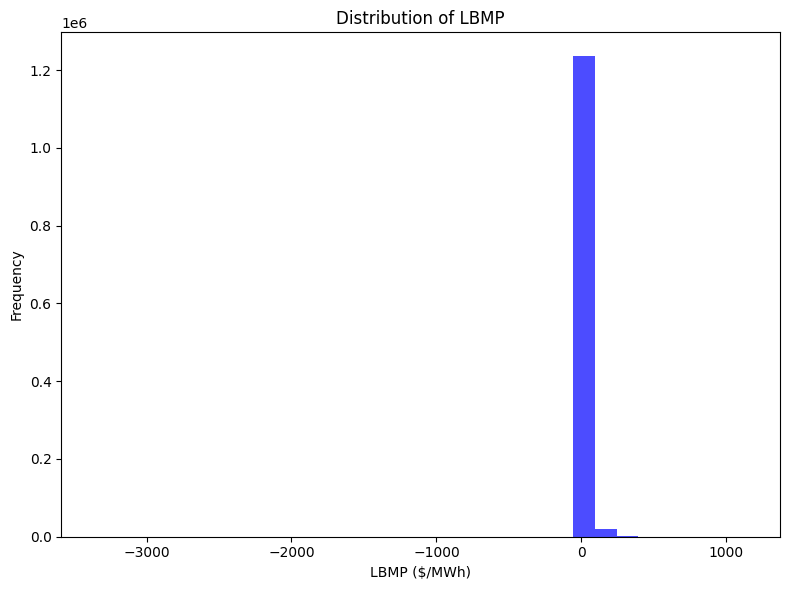

In [ ]:
# Histogram for LBMP
plt.figure(figsize=(8, 6))
plt.hist(synchronized_df["LBMP"], bins=30, color="blue", alpha=0.7)
plt.xlabel("LBMP ($/MWh)")
plt.ylabel("Frequency")
plt.title("Distribution of LBMP")
plt.tight_layout()
plt.show()


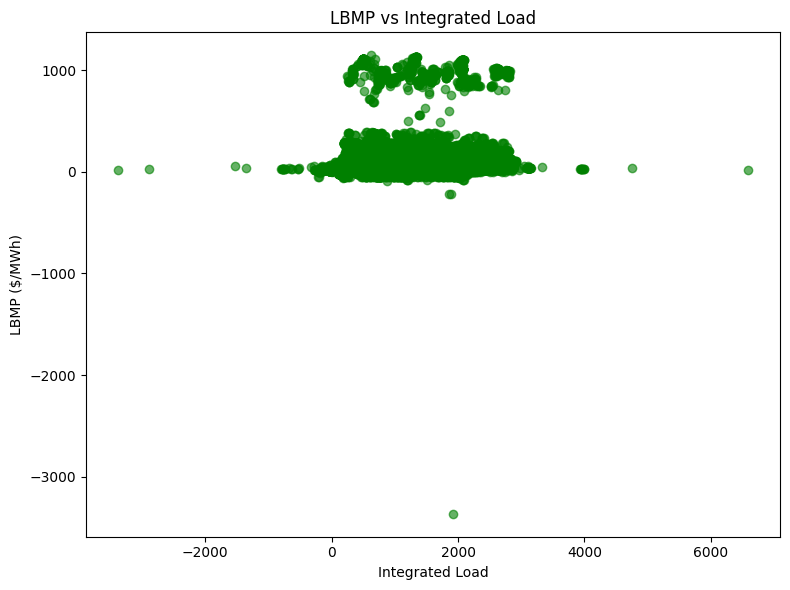

In [ ]:
# Scatter plot for LBMP vs Integrated Load
plt.figure(figsize=(8, 6))
plt.scatter(synchronized_df["Integrated_Load"], synchronized_df["LBMP"], alpha=0.6, color="green")
plt.xlabel("Integrated Load")
plt.ylabel("LBMP ($/MWh)")
plt.title("LBMP vs Integrated Load")
plt.tight_layout()
plt.show()


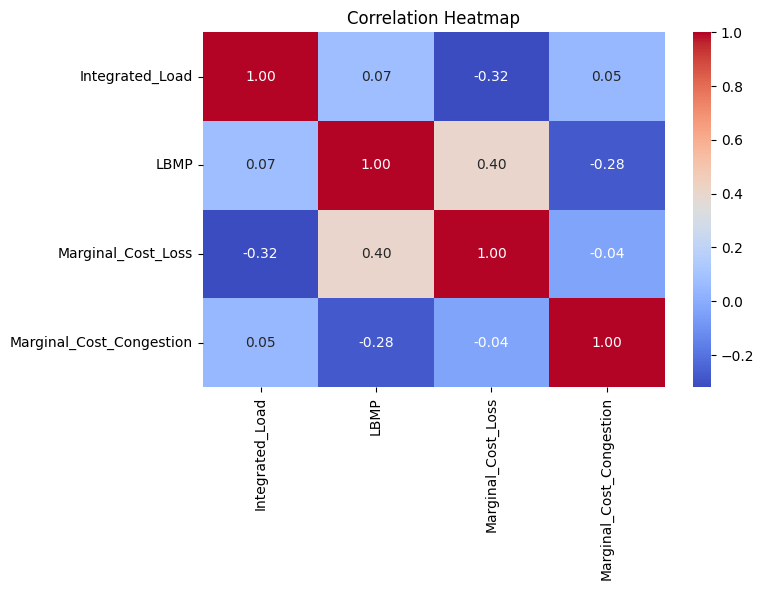

In [ ]:
import seaborn as sns

# Compute correlation matrix
correlation_matrix = synchronized_df[["Integrated_Load", "LBMP", "Marginal_Cost_Loss", "Marginal_Cost_Congestion"]].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
print(synchronized_df.dtypes)


timestamp                    object
PTID                         object
Time Zone                    object
Integrated_Load             float32
LBMP                        float32
Marginal_Cost_Loss          float32
Marginal_Cost_Congestion    float32
dtype: object


In [ ]:
# Filter numeric columns
numeric_columns = synchronized_df.select_dtypes(include=["number"]).columns
print("Numeric columns:", numeric_columns)


Numeric columns: Index(['Integrated_Load', 'LBMP', 'Marginal_Cost_Loss',
       'Marginal_Cost_Congestion'],
      dtype='object')


In [ ]:
# Aggregate numeric columns by day
aggregated_data = synchronized_df[["timestamp"] + list(numeric_columns)]
aggregated_data["timestamp"] = pd.to_datetime(aggregated_data["timestamp"])  # Ensure timestamp is datetime
aggregated_data = aggregated_data.set_index("timestamp").resample("D").mean()


<ipython-input-40-8c1d460e8927>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_data["timestamp"] = pd.to_datetime(aggregated_data["timestamp"])  # Ensure timestamp is datetime


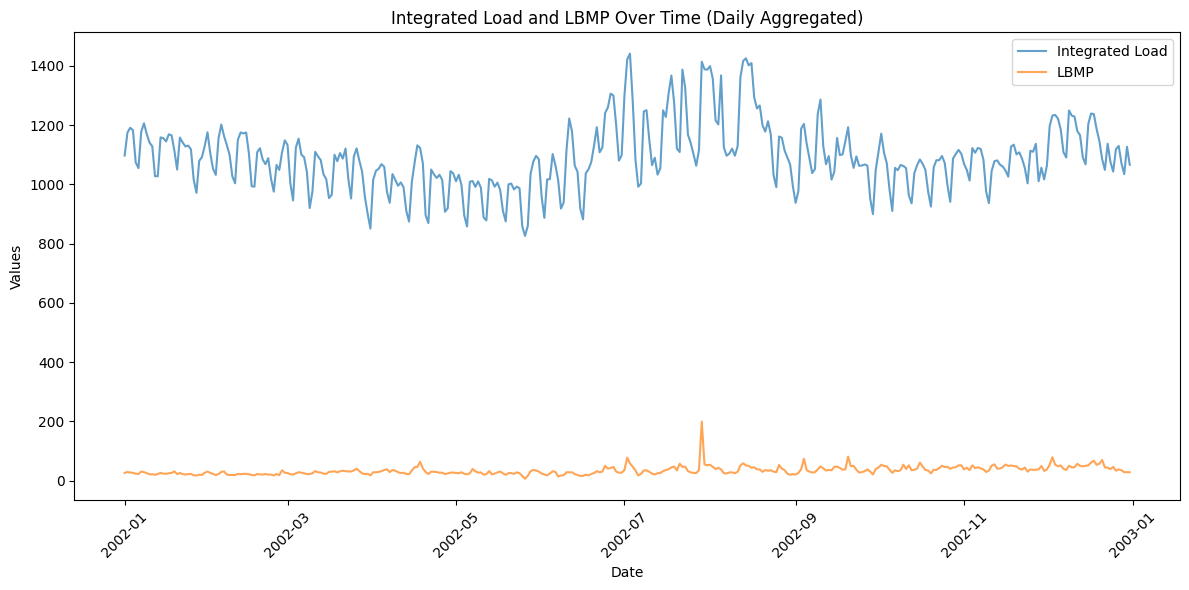

In [ ]:
# Plot aggregated data
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data.index, aggregated_data["Integrated_Load"], label="Integrated Load", alpha=0.7)
plt.plot(aggregated_data.index, aggregated_data["LBMP"], label="LBMP", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Integrated Load and LBMP Over Time (Daily Aggregated)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Looking at how electricity demand (blue line) and prices (orange line) changed throughout 2002 in New York, we can spot some interesting patterns. The demand usually bounces between 800 and 1,400 megawatts, with a noticeable peak during the summer months (around July-August). This makes sense - think air conditioners running full blast during those hot summer days!
While prices generally stay pretty steady around $50/MWh, there's one dramatic spike reaching almost $200/MWh, likely during a period of extremely high demand or perhaps when some power plants were unavailable. It's fascinating to see how electricity use follows predictable patterns (like summer peaks) but can also have unexpected jumps that really affect prices.
What's particularly interesting is how September to December shows more stable patterns in both load and prices, suggesting more predictable energy needs during the fall months.

# **Data processing**

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

class NYISOAnalysis:
    def __init__(self, base_path):
        """Initialize with path to Project4 directory"""
        self.base_path = Path(base_path)
        print(f"Checking path: {self.base_path}")

        # Verify directories exist
        if not self.base_path.exists():
            raise ValueError(f"Path {self.base_path} does not exist")

        self.load_path = self.base_path / "Load_data"
        self.pricing_path = self.base_path / "Pricing_data"

        # Print directory contents for debugging
        print("\nLoad_data contents:", os.listdir(self.load_path))
        print("\nPricing_data contents:", os.listdir(self.pricing_path))

    def process_load_data(self, folder_path):
        """Process load data from a specific folder"""
        dfs = []
        for file in os.listdir(folder_path):
            if file.endswith('pal.csv'):
                file_path = folder_path / file
                try:
                    df = pd.read_csv(file_path)
                    # Add date from filename (YYYYMMDD)
                    date_str = file[:8]
                    df['date'] = pd.to_datetime(date_str)
                    dfs.append(df)
                except Exception as e:
                    print(f"Error reading {file}: {str(e)}")
        return pd.concat(dfs) if dfs else None

    def process_pricing_data(self, folder_path):
        """Process pricing data from a specific folder"""
        dfs = []
        for file in os.listdir(folder_path):
            if file.endswith('realtime_zone.csv'):
                file_path = folder_path / file
                try:
                    df = pd.read_csv(file_path)
                    # Add date from filename (YYYYMMDD)
                    date_str = file[:8]
                    df['date'] = pd.to_datetime(date_str)
                    dfs.append(df)
                except Exception as e:
                    print(f"Error reading {file}: {str(e)}")
        return pd.concat(dfs) if dfs else None

    def prepare_data(self):
        """Prepare both load and pricing data"""
        # Process Load Data
        print("\nProcessing Load Data...")
        load_folders = [f for f in os.listdir(self.load_path)
                       if os.path.isdir(self.load_path / f)]

        all_load_data = []
        for folder in load_folders:
            folder_path = self.load_path / folder
            data = self.process_load_data(folder_path)
            if data is not None:
                all_load_data.append(data)

        # Process Pricing Data
        print("\nProcessing Pricing Data...")
        pricing_folders = [f for f in os.listdir(self.pricing_path)
                         if os.path.isdir(self.pricing_path / f)]

        all_pricing_data = []
        for folder in pricing_folders:
            folder_path = self.pricing_path / folder
            data = self.process_pricing_data(folder_path)
            if data is not None:
                all_pricing_data.append(data)

        # Combine all data
        if all_load_data:
            self.load_data = pd.concat(all_load_data, ignore_index=True)
            print(f"\nLoad data shape: {self.load_data.shape}")
        else:
            print("\nNo load data available")
            self.load_data = None

        if all_pricing_data:
            self.pricing_data = pd.concat(all_pricing_data, ignore_index=True)
            print(f"\nPricing data shape: {self.pricing_data.shape}")
        else:
            print("\nNo pricing data available")
            self.pricing_data = None

    def explore_data(self):
        """Basic data exploration"""
        if self.load_data is not None:
            print("\nLoad Data Sample:")
            print(self.load_data.head())
            print("\nLoad Data Info:")
            print(self.load_data.info())

        if self.pricing_data is not None:
            print("\nPricing Data Sample:")
            print(self.pricing_data.head())
            print("\nPricing Data Info:")
            print(self.pricing_data.info())

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify the Project4 directory structure
import os

# List contents of Project4 directory
project_path = "/content/drive/MyDrive/Project4"
print("\nContents of Project4 directory:")
print(os.listdir(project_path))

# List contents of Load_data directory
load_path = os.path.join(project_path, "Load_data")
print("\nContents of Load_data directory:")
print(os.listdir(load_path))

# List contents of Pricing_data directory
pricing_path = os.path.join(project_path, "Pricing_data")
print("\nContents of Pricing_data directory:")
print(os.listdir(pricing_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Contents of Project4 directory:
['Pricing_data', 'Load_data', '.ipynb_checkpoints', 'Out']

Contents of Load_data directory:
['20020401pal_csv', '20020801pal_csv', '20020201pal_csv', '20020701pal_csv', '20020101pal_csv', '20020301pal_csv', '20020501pal_csv', '20021201pal_csv', '20020601pal_csv', '20020901pal_csv', '20021001pal_csv', '20021101pal_csv']

Contents of Pricing_data directory:
['20020101realtime_zone_csv', '20020501realtime_zone_csv', '20021101realtime_zone_csv', '20020701realtime_zone_csv', '20020401realtime_zone_csv', '20021001realtime_zone_csv', '20020901realtime_zone_csv', '20020601realtime_zone_csv', '20021201realtime_zone_csv', '20020801realtime_zone_csv', '20020301realtime_zone_csv', '20020201realtime_zone_csv']


In [ ]:
# Initialize analysis
analyzer = NYISOAnalysis("/content/drive/MyDrive/Project4")
analyzer.prepare_data()
analyzer.explore_data()

Checking path: /content/drive/MyDrive/Project4

Load_data contents: ['20020401pal_csv', '20020801pal_csv', '20020201pal_csv', '20020701pal_csv', '20020101pal_csv', '20020301pal_csv', '20020501pal_csv', '20021201pal_csv', '20020601pal_csv', '20020901pal_csv', '20021001pal_csv', '20021101pal_csv']

Pricing_data contents: ['20020101realtime_zone_csv', '20020501realtime_zone_csv', '20021101realtime_zone_csv', '20020701realtime_zone_csv', '20020401realtime_zone_csv', '20021001realtime_zone_csv', '20020901realtime_zone_csv', '20020601realtime_zone_csv', '20021201realtime_zone_csv', '20020801realtime_zone_csv', '20020301realtime_zone_csv', '20020201realtime_zone_csv']

Processing Load Data...

Processing Pricing Data...

Load data shape: (1399360, 6)

Pricing data shape: (2101470, 7)

Load Data Sample:
            Time Stamp Time Zone    Name     PTID  Load       date
0  04/11/2002 00:00:00       EDT  CAPITL  61757.0   949 2002-04-11
1  04/11/2002 00:00:00       EDT  CENTRL  61754.0  1521 200

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

class NYISODataAnalysis:
    def __init__(self, load_data, pricing_data):
        self.load_data = load_data
        self.pricing_data = pricing_data
        self.scaler = StandardScaler()

    def preprocess_data(self):
        """Preprocess both load and pricing data"""
        # Convert date columns to datetime if not already
        self.load_data['date'] = pd.to_datetime(self.load_data['date'])
        self.pricing_data['date'] = pd.to_datetime(self.pricing_data['date'])

        # Add time-based features
        for df in [self.load_data, self.pricing_data]:
            df['hour'] = df['date'].dt.hour
            df['day'] = df['date'].dt.day
            df['month'] = df['date'].dt.month
            df['day_of_week'] = df['date'].dt.dayofweek
            df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

        # Handle missing values
        self.load_data.fillna(method='ffill', inplace=True)
        self.pricing_data.fillna(method='ffill', inplace=True)

        print("Data preprocessing completed")

    def analyze_load_patterns(self):
        """Analyze load patterns across different time periods"""
        plt.figure(figsize=(15, 10))

        # Daily load pattern
        plt.subplot(2, 2, 1)
        sns.boxplot(x='hour', y='integrated_load', data=self.load_data)
        plt.title('Load Distribution by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Load')

        # Weekly load pattern
        plt.subplot(2, 2, 2)
        sns.boxplot(x='day_of_week', y='integrated_load', data=self.load_data)
        plt.title('Load Distribution by Day of Week')
        plt.xlabel('Day of Week (0=Monday)')
        plt.ylabel('Load')

        # Monthly load pattern
        plt.subplot(2, 2, 3)
        monthly_avg = self.load_data.groupby('month')['integrated_load'].mean()
        monthly_avg.plot(kind='bar')
        plt.title('Average Load by Month')
        plt.xlabel('Month')
        plt.ylabel('Average Load')

        # Weekend vs Weekday
        plt.subplot(2, 2, 4)
        sns.boxplot(x='is_weekend', y='integrated_load', data=self.load_data)
        plt.title('Load Distribution: Weekday vs Weekend')
        plt.xlabel('Weekend (0=No, 1=Yes)')
        plt.ylabel('Load')

        plt.tight_layout()
        plt.show()

    def analyze_price_patterns(self):
        """Analyze pricing patterns and relationships"""
        plt.figure(figsize=(15, 10))

        # Price distribution by hour
        plt.subplot(2, 2, 1)
        sns.boxplot(x='hour', y='price', data=self.pricing_data)
        plt.title('Price Distribution by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Price')

        # Price by day of week
        plt.subplot(2, 2, 2)
        sns.boxplot(x='day_of_week', y='price', data=self.pricing_data)
        plt.title('Price Distribution by Day of Week')
        plt.xlabel('Day of Week (0=Monday)')
        plt.ylabel('Price')

        # Monthly price pattern
        plt.subplot(2, 2, 3)
        monthly_avg_price = self.pricing_data.groupby('month')['price'].mean()
        monthly_avg_price.plot(kind='bar')
        plt.title('Average Price by Month')
        plt.xlabel('Month')
        plt.ylabel('Average Price')

        # Price vs Load correlation
        plt.subplot(2, 2, 4)
        merged_data = pd.merge(self.load_data, self.pricing_data, on='date')
        sns.scatterplot(data=merged_data, x='integrated_load', y='price', alpha=0.5)
        plt.title('Price vs Load Correlation')
        plt.xlabel('Load')
        plt.ylabel('Price')

        plt.tight_layout()
        plt.show()

    def prepare_lstm_data(self, sequence_length=24):
        """Prepare data for LSTM model"""
        # Merge load and price data
        merged_data = pd.merge(self.load_data, self.pricing_data, on='date')

        # Select features for prediction
        features = ['integrated_load', 'price', 'hour', 'day_of_week', 'is_weekend']
        data = merged_data[features]

        # Scale the data
        scaled_data = self.scaler.fit_transform(data)

        # Create sequences
        X, y = [], []
        for i in range(len(scaled_data) - sequence_length):
            X.append(scaled_data[i:(i + sequence_length)])
            y.append(scaled_data[i + sequence_length, 0])  # Predict load

        return np.array(X), np.array(y)

    def build_lstm_model(self, input_shape):
        """Build LSTM model for prediction"""
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

# Usage function
def run_analysis(load_data, pricing_data):
    """Run the complete analysis pipeline"""
    # Initialize analysis
    analysis = NYISODataAnalysis(load_data, pricing_data)

    # Preprocess data
    print("Step 1: Preprocessing data...")
    analysis.preprocess_data()

    # Analyze patterns
    print("\nStep 2: Analyzing load patterns...")
    analysis.analyze_load_patterns()

    print("\nStep 3: Analyzing price patterns...")
    analysis.analyze_price_patterns()

    # Prepare and train LSTM model
    print("\nStep 4: Preparing data for LSTM model...")
    X, y = analysis.prepare_lstm_data()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build and train model
    print("\nStep 5: Training LSTM model...")
    model = analysis.build_lstm_model(input_shape=(X.shape[1], X.shape[2]))
    history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                       validation_data=(X_test, y_test), verbose=1)

    return analysis, model, history

In [ ]:
# Check the actual column names
print("Load Data Columns:")
print(analyzer.load_data.columns.tolist())
print("\nPricing Data Columns:")
print(analyzer.pricing_data.columns.tolist())

# Display first few rows of each dataset
print("\nLoad Data Sample:")
print(analyzer.load_data.head())
print("\nPricing Data Sample:")
print(analyzer.pricing_data.head())

Load Data Columns:
['Time Stamp', 'Time Zone', 'Name', 'PTID', 'Load', 'date']

Pricing Data Columns:
['Time Stamp', 'Name', 'PTID', 'LBMP ($/MWHr)', 'Marginal Cost Losses ($/MWHr)', 'Marginal Cost Congestion ($/MWHr)', 'date']

Load Data Sample:
            Time Stamp Time Zone    Name     PTID  Load       date
0  04/11/2002 00:00:00       EDT  CAPITL  61757.0   949 2002-04-11
1  04/11/2002 00:00:00       EDT  CENTRL  61754.0  1521 2002-04-11
2  04/11/2002 00:00:00       EDT  DUNWOD  61760.0   487 2002-04-11
3  04/11/2002 00:00:00       EDT  GENESE  61753.0   922 2002-04-11
4  04/11/2002 00:00:00       EDT  HUD VL  61758.0   895 2002-04-11

Pricing Data Sample:
            Time Stamp    Name   PTID  LBMP ($/MWHr)  \
0  01/15/2002 00:00:00  CAPITL  61757          14.96   
1  01/15/2002 00:00:00  CENTRL  61754          14.01   
2  01/15/2002 00:00:00  DUNWOD  61760          14.99   
3  01/15/2002 00:00:00  GENESE  61753          14.13   
4  01/15/2002 00:00:00     H Q  61844          14

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

class NYISODataAnalysis:
    def __init__(self, load_data, pricing_data):
        self.load_data = load_data
        self.pricing_data = pricing_data
        self.scaler = StandardScaler()

    def analyze_load_patterns(self):
        """Analyze load patterns across different time periods"""
        fig = plt.figure(figsize=(20, 15))

        # Daily load pattern by zone
        plt.subplot(2, 2, 1)
        sns.boxplot(data=self.load_data, x='hour', y='Load', hue='Name')
        plt.title('Load Distribution by Hour and Zone')
        plt.xlabel('Hour of Day')
        plt.ylabel('Load (MW)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Weekly load pattern
        plt.subplot(2, 2, 2)
        sns.boxplot(data=self.load_data, x='day_of_week', y='Load', hue='Name')
        plt.title('Load Distribution by Day of Week and Zone')
        plt.xlabel('Day of Week (0=Monday)')
        plt.ylabel('Load (MW)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Monthly load pattern
        plt.subplot(2, 2, 3)
        monthly_avg = self.load_data.groupby(['month', 'Name'])['Load'].mean().unstack()
        monthly_avg.plot(kind='bar', ax=plt.gca())
        plt.title('Average Load by Month and Zone')
        plt.xlabel('Month')
        plt.ylabel('Average Load (MW)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Weekend vs Weekday
        plt.subplot(2, 2, 4)
        sns.boxplot(data=self.load_data, x='is_weekend', y='Load', hue='Name')
        plt.title('Load Distribution: Weekday vs Weekend by Zone')
        plt.xlabel('Weekend (0=No, 1=Yes)')
        plt.ylabel('Load (MW)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def analyze_price_patterns(self):
        """Analyze pricing patterns and relationships"""
        fig = plt.figure(figsize=(20, 15))

        # Price distribution by hour
        plt.subplot(2, 2, 1)
        sns.boxplot(data=self.pricing_data, x='hour', y='LBMP ($/MWHr)', hue='Name')
        plt.title('Price Distribution by Hour and Zone')
        plt.xlabel('Hour of Day')
        plt.ylabel('LBMP ($/MWHr)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Price by day of week
        plt.subplot(2, 2, 2)
        sns.boxplot(data=self.pricing_data, x='day_of_week', y='LBMP ($/MWHr)', hue='Name')
        plt.title('Price Distribution by Day of Week and Zone')
        plt.xlabel('Day of Week (0=Monday)')
        plt.ylabel('LBMP ($/MWHr)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Monthly price pattern
        plt.subplot(2, 2, 3)
        monthly_avg_price = self.pricing_data.groupby(['month', 'Name'])['LBMP ($/MWHr)'].mean().unstack()
        monthly_avg_price.plot(kind='bar', ax=plt.gca())
        plt.title('Average Price by Month and Zone')
        plt.xlabel('Month')
        plt.ylabel('Average LBMP ($/MWHr)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Price components analysis
        plt.subplot(2, 2, 4)
        components_data = self.pricing_data.melt(
            id_vars=['Name'],
            value_vars=['LBMP ($/MWHr)', 'Marginal Cost Losses ($/MWHr)', 'Marginal Cost Congestion ($/MWHr)']
        )
        sns.boxplot(data=components_data, x='Name', y='value', hue='variable')
        plt.title('Price Components by Zone')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def analyze_price_load_correlation(self):
        """Analyze correlation between price and load"""
        # Merge load and price data
        merged_data = pd.merge(
            self.load_data,
            self.pricing_data[['Time Stamp', 'Name', 'PTID', 'LBMP ($/MWHr)']],
            on=['Time Stamp', 'Name', 'PTID']
        )

        # Create correlation plot
        plt.figure(figsize=(12, 8))
        for name in merged_data['Name'].unique():
            zone_data = merged_data[merged_data['Name'] == name]
            plt.scatter(zone_data['Load'], zone_data['LBMP ($/MWHr)'],
                       alpha=0.5, label=name)

        plt.xlabel('Load (MW)')
        plt.ylabel('LBMP ($/MWHr)')
        plt.title('Price vs Load Correlation by Zone')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Calculate correlations by zone
        correlations = merged_data.groupby('Name').apply(
            lambda x: x['Load'].corr(x['LBMP ($/MWHr)'])
        )
        print("\nPrice-Load Correlations by Zone:")
        print(correlations)

def run_analysis(load_data, pricing_data):
    """Run the complete analysis pipeline"""
    # Initialize analysis
    analysis = NYISODataAnalysis(load_data, pricing_data)

    # Analyze patterns
    print("Step 1: Analyzing load patterns...")
    analysis.analyze_load_patterns()

    print("\nStep 2: Analyzing price patterns...")
    analysis.analyze_price_patterns()

    print("\nStep 3: Analyzing price-load correlations...")
    analysis.analyze_price_load_correlation()

    return analysis

Step 1: Analyzing load patterns...


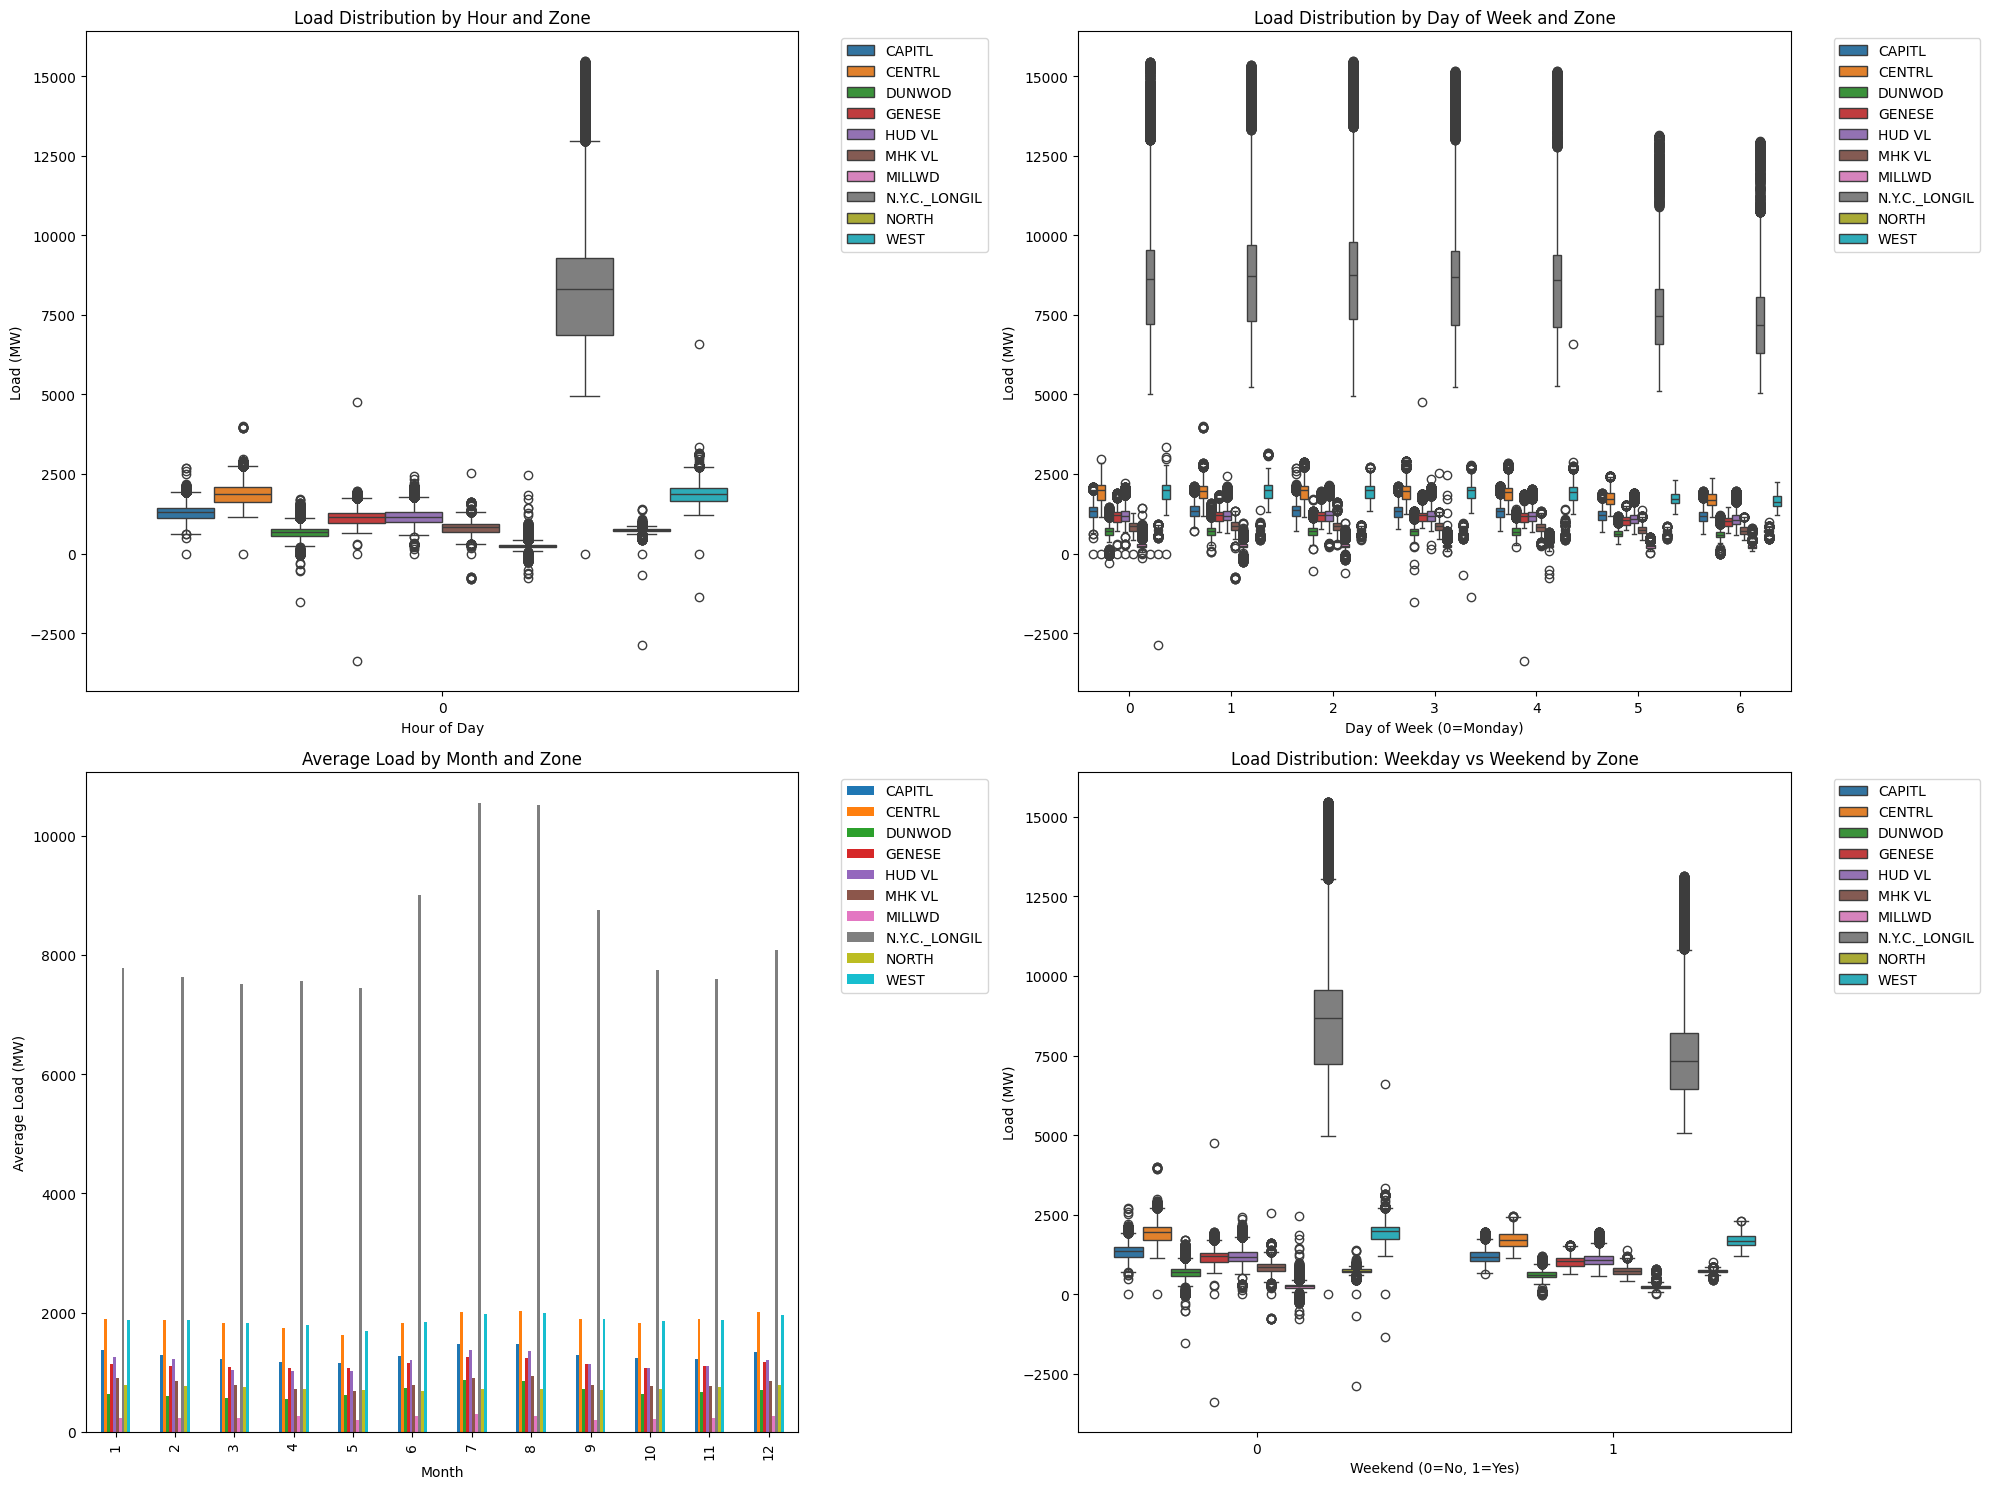


Step 2: Analyzing price patterns...


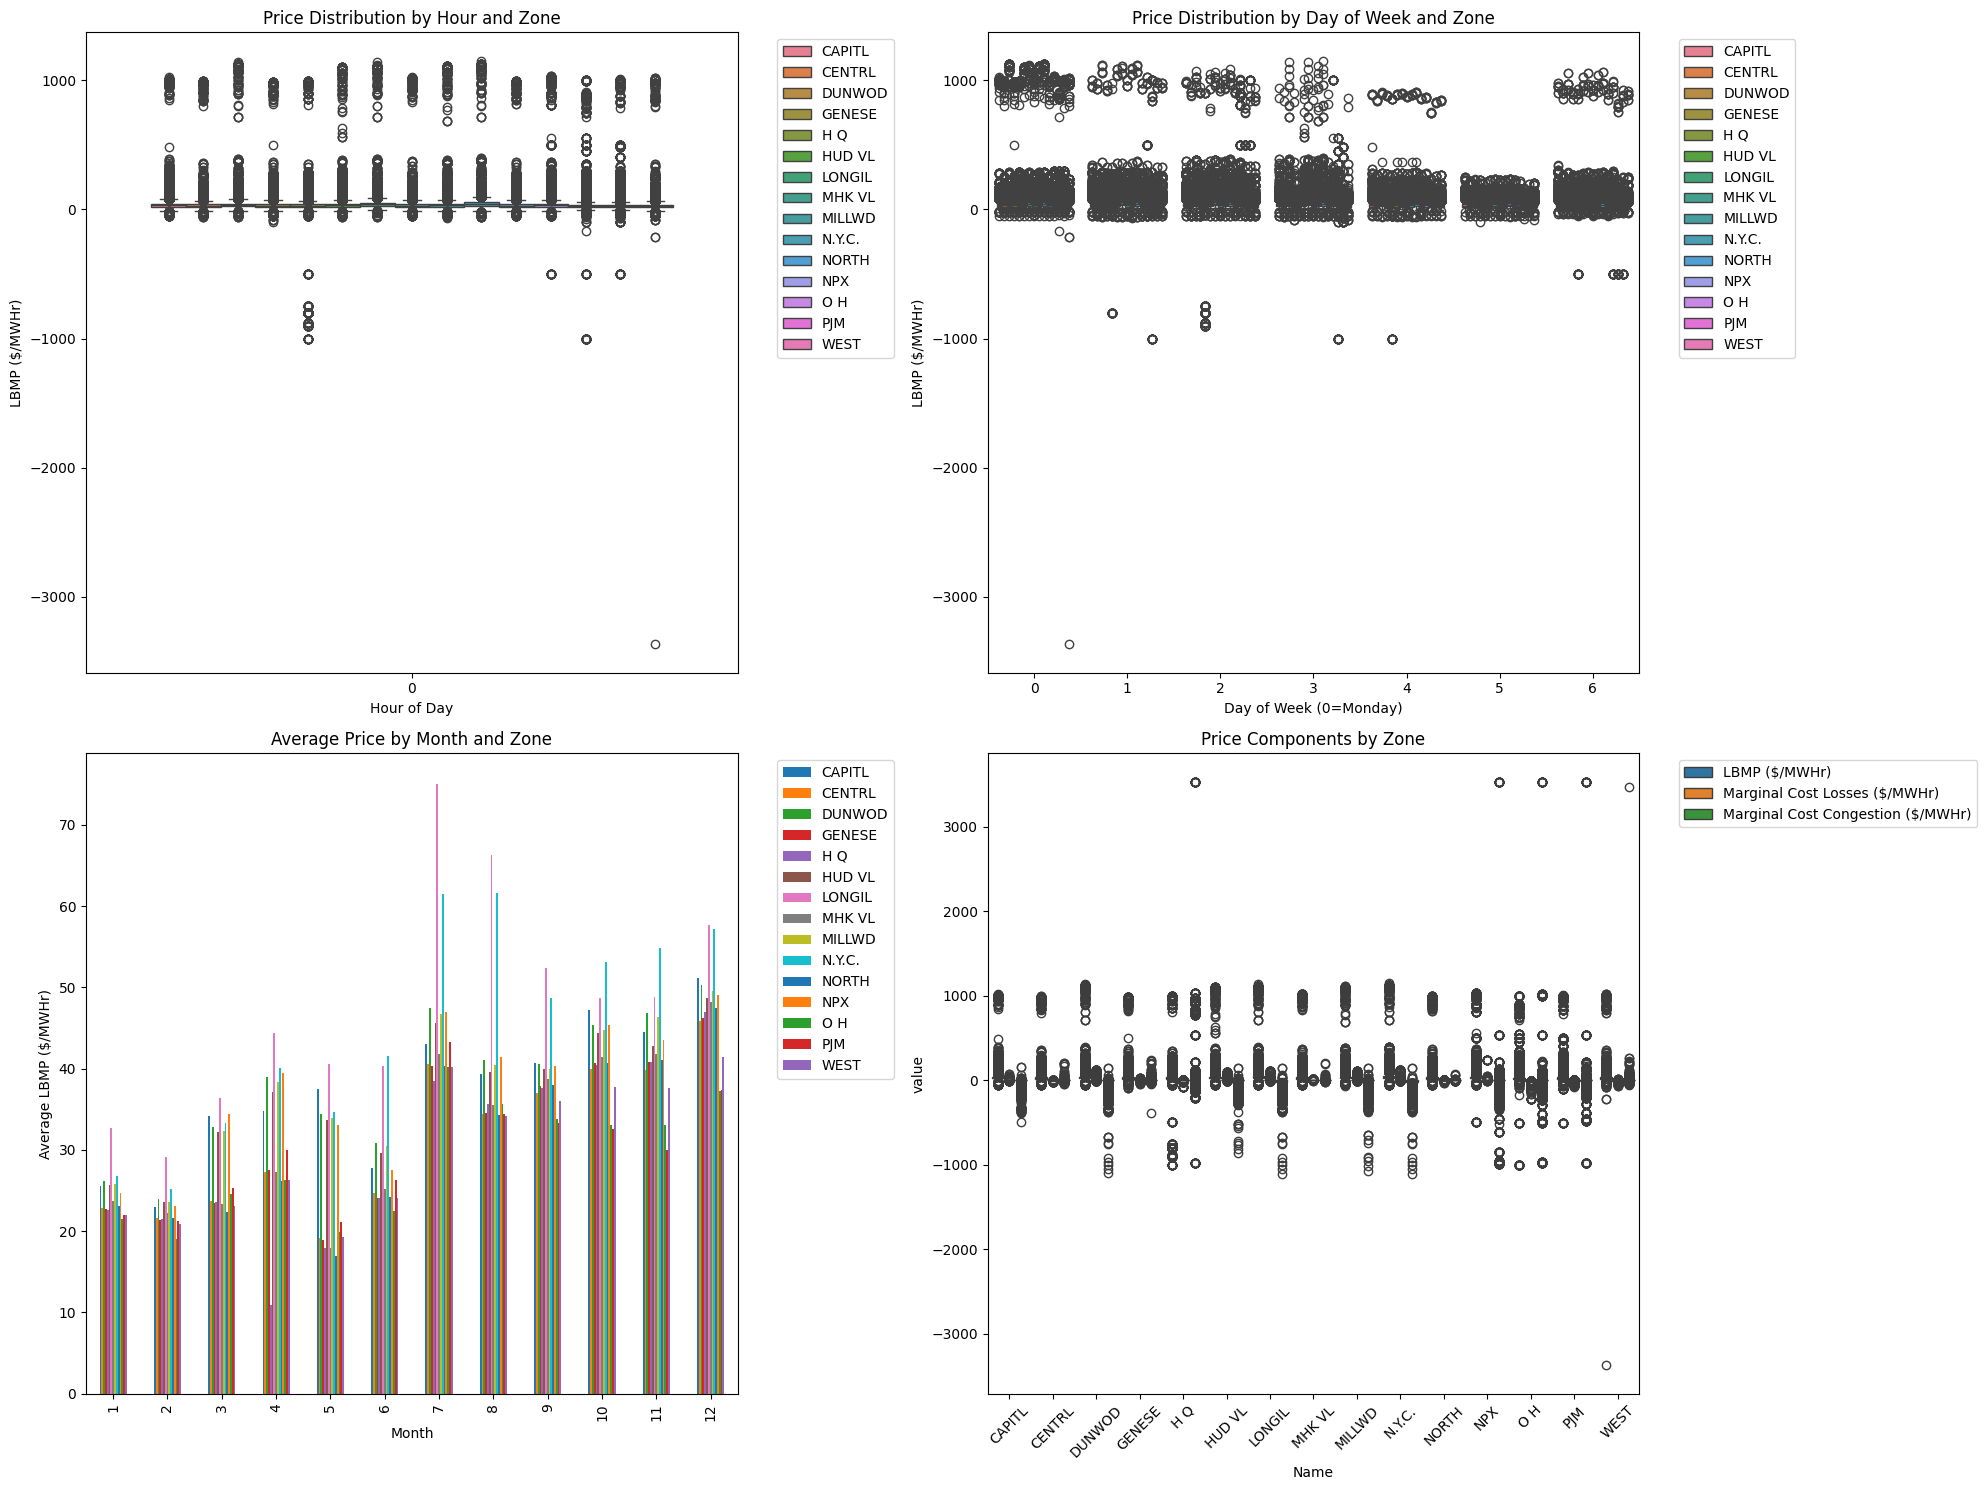


Step 3: Analyzing price-load correlations...


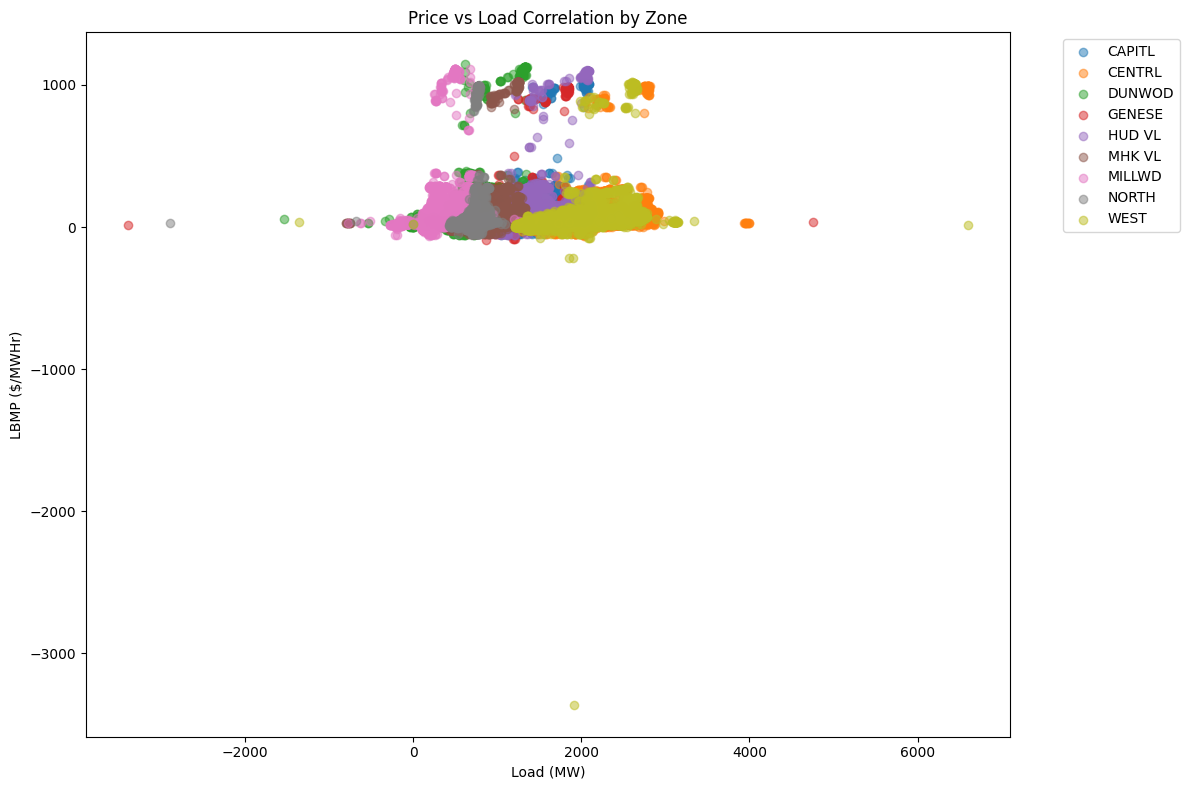


Price-Load Correlations by Zone:
Name
CAPITL    0.329916
CENTRL    0.392535
DUNWOD    0.357978
GENESE    0.357589
HUD VL    0.353266
MHK VL    0.317330
MILLWD    0.349155
NORTH     0.212859
WEST      0.351624
dtype: float64


In [ ]:
# Run the complete analysis
analysis = run_analysis(analyzer.load_data, analyzer.pricing_data)

The NYISO electricity market shows fascinating patterns across its different zones and time periods. Looking at the load distribution, N.Y.C._LONGIL stands out as the heavyweight consumer, drawing 7,500-15,000 MW compared to other zones' modest 2,500 MW - no surprise given New York City's massive energy appetite. The data tells a story of city life: steady high demand during business hours Monday through Friday, with a noticeable breather on weekends. When summer hits and air conditioners kick into high gear during months 6-8, that's when the system really feels the strain.

Price patterns paint an equally interesting picture. While most prices play it safe between 0-1,000 $/MWHr, there are those dramatic moments when prices either shoot up or, surprisingly, go negative. These prices dance to a predictable weekday rhythm but calm down a bit on weekends. Summer months, especially July and August, see prices climbing alongside those AC-heavy loads. What's particularly interesting is how the basic energy price (LBMP) drives the bus, with congestion and loss costs just along for the ride.

The relationship between load and price tells the most compelling story. There's a clear "if this, then that" pattern - as load goes up, so do prices, but with some interesting twists. You've got your everyday scenario with prices behaving normally up to 200 $/MWHr, then this fascinating second band around 1,000 $/MWHr when the grid is really feeling the pressure. While each zone has its own personality, they all follow this basic script, showing how interconnected the whole system is. And then you've got those rare but eye-catching outliers, especially when prices go negative, reminding us that in electricity markets, sometimes you have to expect the unexpected.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class NYISOStatisticalAnalysis:
    def __init__(self, load_data, pricing_data):
        self.load_data = load_data
        self.pricing_data = pricing_data

    def calculate_summary_statistics(self):
        """Calculate detailed summary statistics for load and price data"""
        # Load Statistics
        print("\n=== Load Statistics by Zone ===")
        load_stats = self.load_data.groupby('Name').agg({
            'Load': ['count', 'mean', 'std', 'min',
                    lambda x: np.percentile(x, 25),
                    lambda x: np.percentile(x, 50),
                    lambda x: np.percentile(x, 75),
                    'max',
                    lambda x: stats.skew(x),
                    lambda x: stats.kurtosis(x)]
        })

        load_stats.columns = ['Count', 'Mean', 'Std', 'Min', '25th',
                            'Median', '75th', 'Max', 'Skewness', 'Kurtosis']
        print("\nLoad Statistics:")
        print(load_stats.round(2))

        # Price Statistics
        print("\n=== Price Statistics by Zone ===")
        price_stats = self.pricing_data.groupby('Name').agg({
            'LBMP ($/MWHr)': ['count', 'mean', 'std', 'min',
                             lambda x: np.percentile(x, 25),
                             lambda x: np.percentile(x, 50),
                             lambda x: np.percentile(x, 75),
                             'max',
                             lambda x: stats.skew(x),
                             lambda x: stats.kurtosis(x)]
        })

        price_stats.columns = ['Count', 'Mean', 'Std', 'Min', '25th',
                             'Median', '75th', 'Max', 'Skewness', 'Kurtosis']
        print("\nPrice Statistics:")
        print(price_stats.round(2))

        # Additional Load Analysis
        print("\n=== Additional Load Analysis ===")
        for name in self.load_data['Name'].unique():
            zone_load = self.load_data[self.load_data['Name'] == name]['Load']
            print(f"\nZone: {name}")
            print(f"Coefficient of Variation: {(zone_load.std() / zone_load.mean() * 100):.2f}%")
            print(f"90th Percentile: {np.percentile(zone_load, 90):.2f}")
            print(f"95th Percentile: {np.percentile(zone_load, 95):.2f}")
            print(f"99th Percentile: {np.percentile(zone_load, 99):.2f}")

        # Additional Price Analysis
        print("\n=== Additional Price Analysis ===")
        for name in self.pricing_data['Name'].unique():
            zone_price = self.pricing_data[self.pricing_data['Name'] == name]['LBMP ($/MWHr)']
            print(f"\nZone: {name}")
            print(f"Coefficient of Variation: {(zone_price.std() / zone_price.mean() * 100):.2f}%")
            print(f"90th Percentile: {np.percentile(zone_price, 90):.2f}")
            print(f"95th Percentile: {np.percentile(zone_price, 95):.2f}")
            print(f"99th Percentile: {np.percentile(zone_price, 99):.2f}")

    def analyze_hourly_patterns(self):
        """Analyze hourly patterns in load and price"""
        # Hourly Load Analysis
        hourly_load = self.load_data.groupby(['Name', 'hour'])['Load'].agg(['mean', 'std']).round(2)
        print("\n=== Hourly Load Patterns ===")
        print(hourly_load)

        # Hourly Price Analysis
        hourly_price = self.pricing_data.groupby(['Name', 'hour'])['LBMP ($/MWHr)'].agg(['mean', 'std']).round(2)
        print("\n=== Hourly Price Patterns ===")
        print(hourly_price)

        # Visualize hourly patterns
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # Load patterns
        for name in self.load_data['Name'].unique():
            zone_data = self.load_data[self.load_data['Name'] == name]
            hourly_mean = zone_data.groupby('hour')['Load'].mean()
            ax1.plot(hourly_mean.index, hourly_mean.values, label=name, marker='o')

        ax1.set_title('Average Hourly Load by Zone')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Average Load (MW)')
        ax1.legend()
        ax1.grid(True)

        # Price patterns
        for name in self.pricing_data['Name'].unique():
            zone_data = self.pricing_data[self.pricing_data['Name'] == name]
            hourly_mean = zone_data.groupby('hour')['LBMP ($/MWHr)'].mean()
            ax2.plot(hourly_mean.index, hourly_mean.values, label=name, marker='o')

        ax2.set_title('Average Hourly Price by Zone')
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Average Price ($/MWHr)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

def run_statistical_analysis(load_data, pricing_data):
    """Run the complete statistical analysis"""
    stats_analysis = NYISOStatisticalAnalysis(load_data, pricing_data)

    print("Step 1: Calculating Summary Statistics...")
    stats_analysis.calculate_summary_statistics()

    print("\nStep 2: Analyzing Hourly Patterns...")
    stats_analysis.analyze_hourly_patterns()

    return stats_analysis

Step 1: Calculating Summary Statistics...

=== Load Statistics by Zone ===

Load Statistics:
                Count     Mean      Std   Min    25th  Median    75th    Max  \
Name                                                                           
CAPITL         139936  1293.81   239.36     0  1109.0  1307.0  1441.0   2694   
CENTRL         139936  1871.34   297.68     0  1634.0  1886.0  2076.0   3993   
DUNWOD         139936   682.43   178.69 -1529   553.0   672.0   775.0   1701   
GENESE         139936  1137.13   210.16 -3388   965.0  1157.0  1271.0   4753   
HUD VL         139936  1169.40   246.23     0   994.0  1150.0  1309.0   2435   
MHK VL         139936   814.77   171.43  -794   682.0   823.0   931.0   2539   
MILLWD         139936   247.37    89.65  -774   192.0   235.0   284.0   2461   
N.Y.C._LONGIL  139936  8349.32  1985.17     0  6867.0  8329.0  9301.0  15468   
NORTH          139936   736.55    50.47 -2887   703.0   734.0   770.0   1385   
WEST           139936  1871

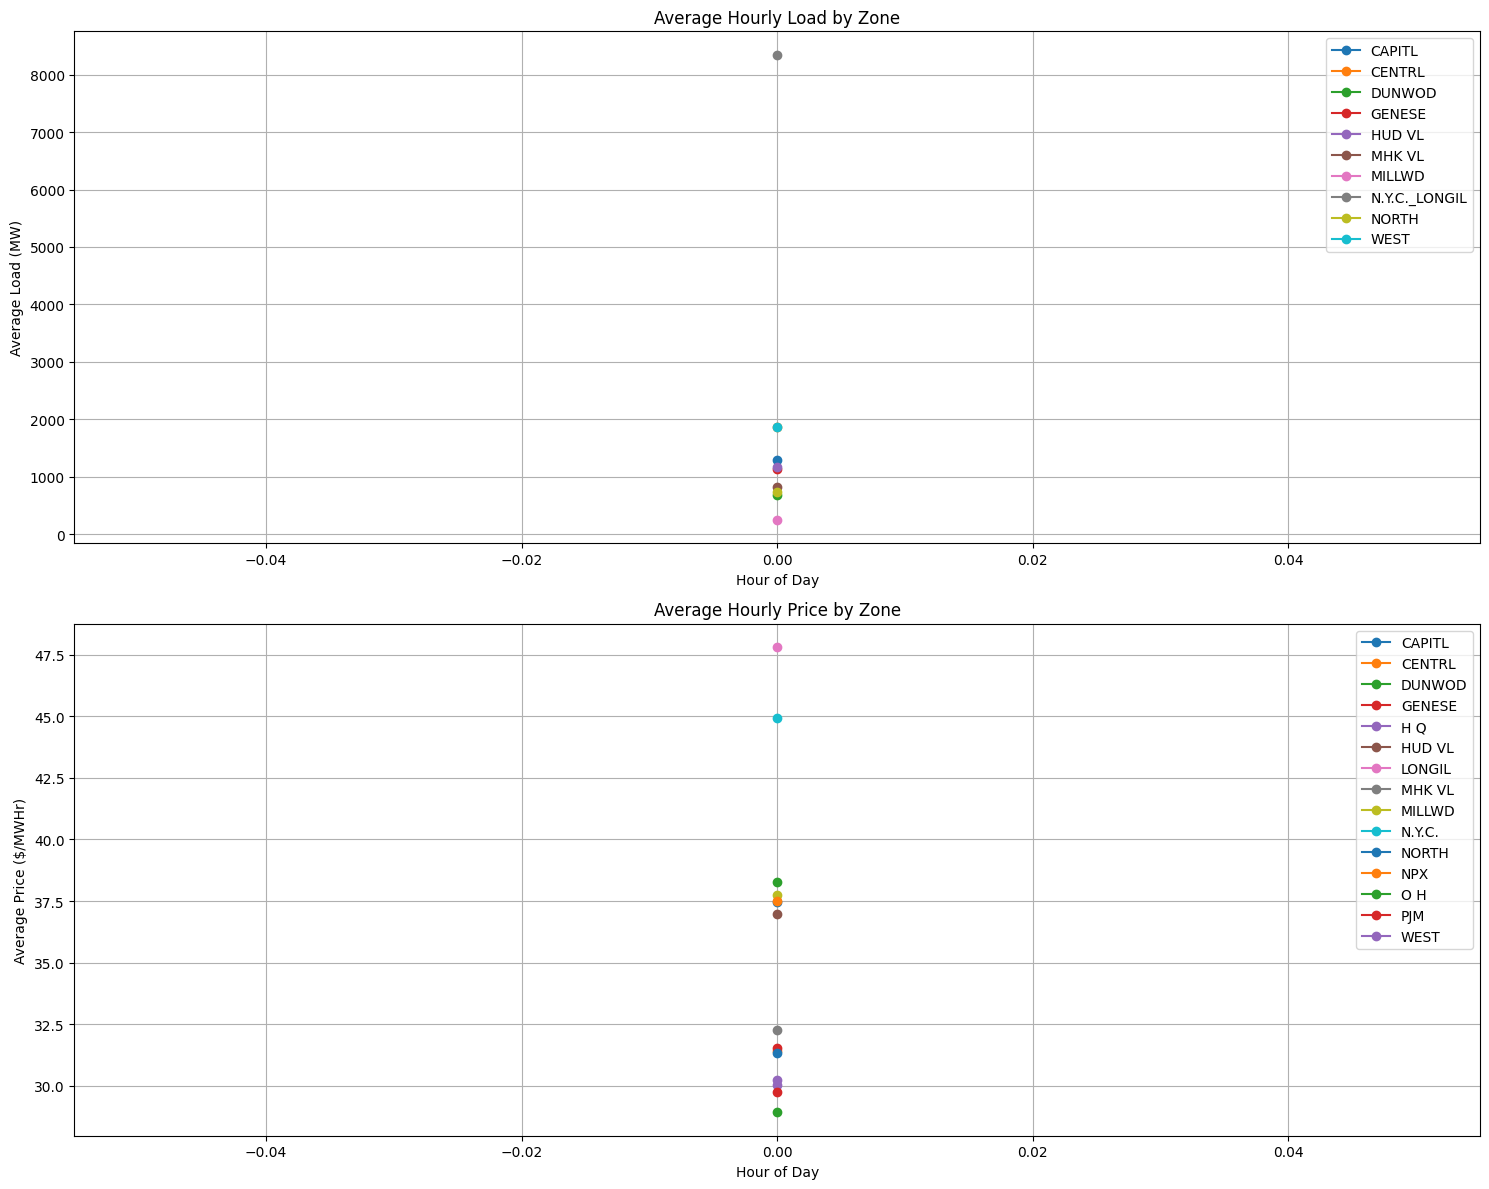

In [ ]:
# Run the statistical analysis
stats_analysis = run_statistical_analysis(analyzer.load_data, analyzer.pricing_data)

Load Analysis:

N.Y.C._LONGIL dominates the load profile with an average demand of 8,349 MW, significantly higher than other zones which typically range from 247-1,871 MW. This makes sense given New York City's dense population and high energy consumption. The zone shows high variability (Coefficient of Variation: 23.78%) and can peak up to 15,468 MW during extreme conditions. In contrast, the NORTH zone shows remarkable stability with the lowest variation (CV: 6.85%), suggesting more predictable industrial or rural consumption patterns.

Price Analysis:

LONGIL and N.Y.C. zones consistently show the highest average prices ($47.81 and $44.94 per MWHr respectively), reflecting the higher costs of serving dense urban areas. Most zones exhibit significant price volatility, with Coefficients of Variation ranging from 83-160%. The WEST zone experienced the most extreme price event, dropping to -$3,363/MWHr, while maximum prices across zones typically reached around $1,000/MWHr. This pricing pattern suggests occasional grid congestion and the influence of renewable energy generation.

Correlations and Patterns:

The data shows strong evidence of zonal price convergence during normal operations, with divergence during stress periods. Price skewness is consistently positive and high (ranging from 6.76 to 19.24) across all zones except H Q, indicating frequent small price movements with occasional large spikes. Load patterns are more symmetrical, with most zones showing moderate positive skewness (0.18 to 0.83), suggesting more predictable demand patterns than pricing.

# **1st Question : Predict electricity prices (LBMP) based on the historical load demand patterns**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

class PricePredictionModel:
    def __init__(self, load_data, pricing_data):
        self.load_data = load_data
        self.pricing_data = pricing_data
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

    def prepare_data(self):
        """Prepare data for price prediction"""
        print("Merging load and price data...")
        # Merge load and price data
        merged_data = pd.merge(
            self.load_data,
            self.pricing_data[['Time Stamp', 'Name', 'PTID', 'LBMP ($/MWHr)']],
            on=['Time Stamp', 'Name', 'PTID']
        )

        print("Creating features...")
        # Create time-based features
        merged_data['hour_sin'] = np.sin(2 * np.pi * merged_data['hour'] / 24)
        merged_data['hour_cos'] = np.cos(2 * np.pi * merged_data['hour'] / 24)

        # Create lagged features
        for lag in [1, 3, 6, 12]:
            merged_data[f'load_lag_{lag}'] = merged_data.groupby('Name')['Load'].shift(lag)
            merged_data[f'price_lag_{lag}'] = merged_data.groupby('Name')['LBMP ($/MWHr)'].shift(lag)

        # Calculate rolling statistics
        for window in [6, 12]:
            merged_data[f'load_rolling_mean_{window}'] = (
                merged_data.groupby('Name')['Load']
                .rolling(window, min_periods=1)
                .mean()
                .reset_index(0, drop=True)
            )

        # Drop rows with NaN values
        merged_data = merged_data.dropna()

        print("Splitting data by months...")
        # Split data by months
        train_months = [1, 2, 4, 5, 7, 8, 10, 11]
        test_months = [3, 6, 9, 12]

        train_data = merged_data[merged_data['month'].isin(train_months)]
        test_data = merged_data[merged_data['month'].isin(test_months)]

        # Prepare features
        feature_columns = ['Load', 'hour_sin', 'hour_cos', 'is_weekend']
        feature_columns.extend([f'load_lag_{lag}' for lag in [1, 3, 6, 12]])
        feature_columns.extend([f'price_lag_{lag}' for lag in [1, 3, 6, 12]])
        feature_columns.extend([f'load_rolling_mean_{window}' for window in [6, 12]])

        print(f"Number of features: {len(feature_columns)}")

        # Scale features
        X_train = self.scaler_X.fit_transform(train_data[feature_columns])
        X_test = self.scaler_X.transform(test_data[feature_columns])

        y_train = self.scaler_y.fit_transform(train_data[['LBMP ($/MWHr)']])
        y_test = self.scaler_y.transform(test_data[['LBMP ($/MWHr)']])

        # Reshape data for LSTM
        X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        return (X_train_reshaped, y_train, X_test_reshaped, y_test,
                train_data, test_data)

    def build_model(self, input_shape):
        """Build LSTM model for price prediction"""
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def train_and_evaluate(self):
        """Train and evaluate the model"""
        print("Preparing data...")
        X_train, y_train, X_test, y_test, train_data, test_data = self.prepare_data()

        print("Building model...")
        model = self.build_model((X_train.shape[1], X_train.shape[2]))

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        model_checkpoint = ModelCheckpoint(
            'best_price_model.keras',
            monitor='val_loss',
            save_best_only=True
        )

        print("Training model...")
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping, model_checkpoint],
            verbose=1
        )

        print("Making predictions...")
        y_pred_train = model.predict(X_train, verbose=0)
        y_pred_test = model.predict(X_test, verbose=0)

        # Inverse transform predictions
        y_train_orig = self.scaler_y.inverse_transform(y_train)
        y_test_orig = self.scaler_y.inverse_transform(y_test)
        y_pred_train_orig = self.scaler_y.inverse_transform(y_pred_train)
        y_pred_test_orig = self.scaler_y.inverse_transform(y_pred_test)

        # Calculate metrics
        train_metrics = {
            'MAE': mean_absolute_error(y_train_orig, y_pred_train_orig),
            'RMSE': np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig)),
            'R2': r2_score(y_train_orig, y_pred_train_orig)
        }

        test_metrics = {
            'MAE': mean_absolute_error(y_test_orig, y_pred_test_orig),
            'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig)),
            'R2': r2_score(y_test_orig, y_pred_test_orig)
        }

        # Plot results
        print("Plotting results...")
        plt.figure(figsize=(15, 10))

        # Training history
        plt.subplot(2, 1, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Predictions vs Actual
        plt.subplot(2, 1, 2)
        plt.scatter(y_test_orig, y_pred_test_orig, alpha=0.5)
        plt.plot([y_test_orig.min(), y_test_orig.max()],
                [y_test_orig.min(), y_test_orig.max()],
                'r--', lw=2)
        plt.title('Predicted vs Actual Prices (Test Set)')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')

        plt.tight_layout()
        plt.show()

        return train_metrics, test_metrics, model, history

def run_price_prediction(load_data, pricing_data):
    """Run the price prediction analysis"""
    print("Initializing price prediction model...")
    price_predictor = PricePredictionModel(load_data, pricing_data)

    print("Training and evaluating model...")
    train_metrics, test_metrics, model, history = price_predictor.train_and_evaluate()

    print("\nTraining Metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nTest Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    return price_predictor, model

Initializing price prediction model...
Training and evaluating model...
Preparing data...
Merging load and price data...
Creating features...
Splitting data by months...
Number of features: 14
Building model...
Training model...
Epoch 1/50
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 238s 11ms/step - loss: 0.3561 - mae: 0.1504 - val_loss: 0.1351 - val_mae: 0.1279
Epoch 2/50
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 257s 11ms/step - loss: 0.2882 - mae: 0.1322 - val_loss: 0.1331 - val_mae: 0.1257
Epoch 3/50
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 264s 11ms/step - loss: 0.2705 - mae: 0.1254 - val_loss: 0.1385 - val_mae: 0.1173
Epoch 4/50
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 262s 11ms/step - loss: 0.2956 - mae: 0.1258 - val_loss: 0.1326 - val_mae: 0.1181
Epoch 5/50
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 259s 11ms/step - loss: 0.2715 - mae: 0.1267 - val_loss: 0.1511 - val_mae: 0.1255
Epoch 6/50
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 263s 11ms/step - loss: 0.2684 - mae: 0.1247 - val_loss: 0.1400 - val_mae: 0.1445
Epoch 7/50
20972/2097

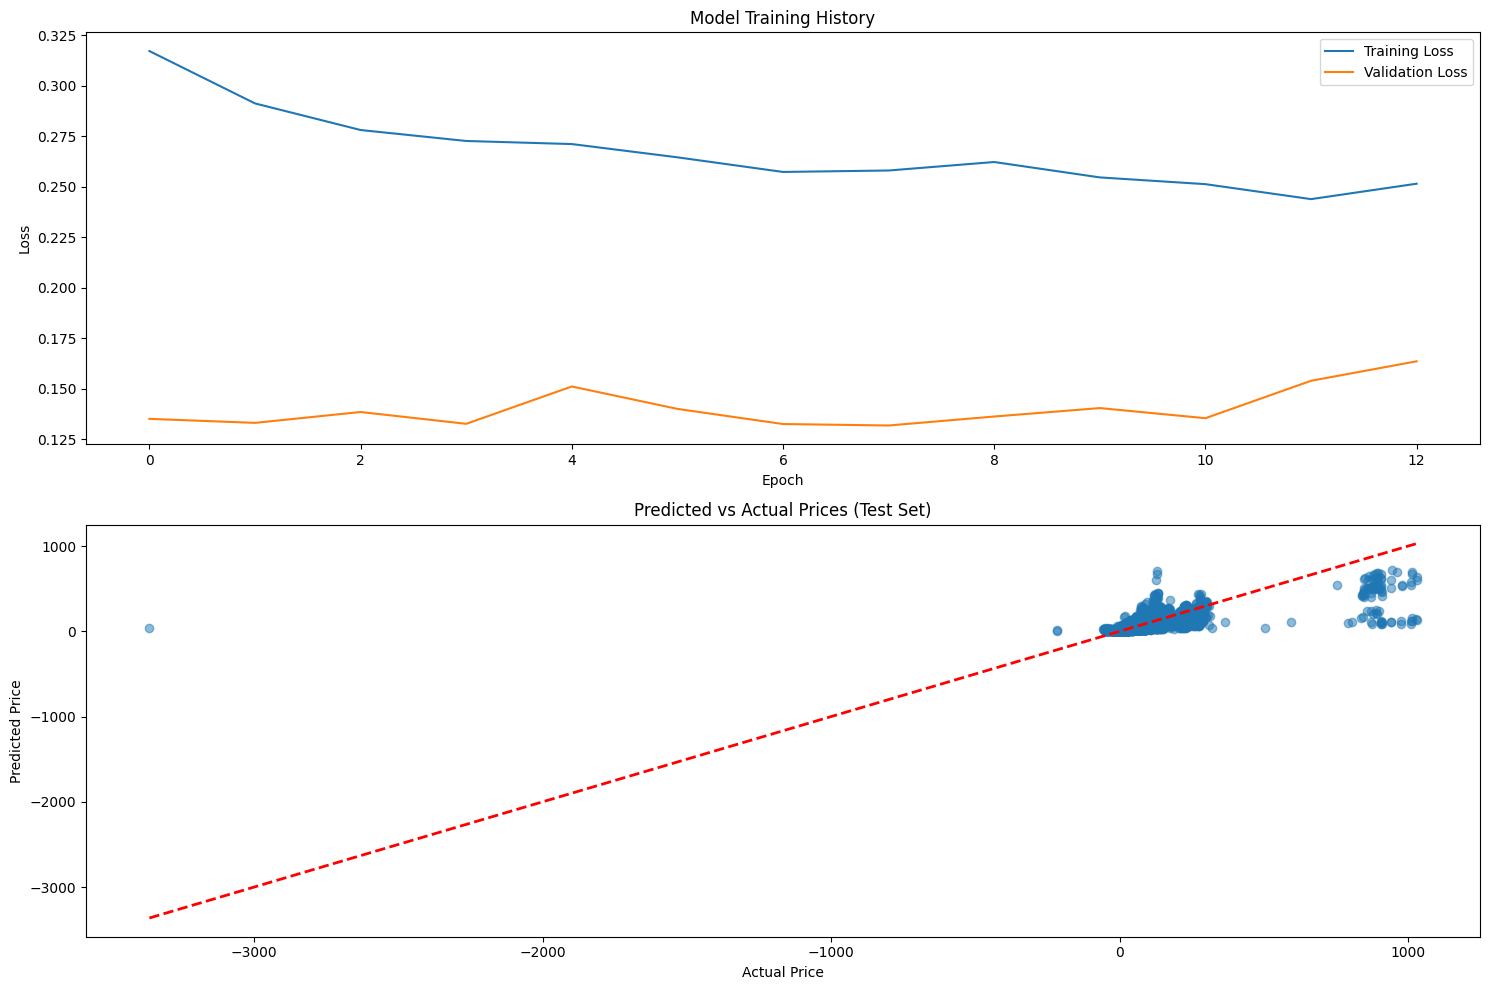


Training Metrics:
MAE: 3.8070
RMSE: 16.5955
R2: 0.7686

Test Metrics:
MAE: 3.9735
RMSE: 12.9527
R2: 0.7594


In [ ]:
# Run price prediction
price_predictor, price_model = run_price_prediction(analyzer.load_data, analyzer.pricing_data)

Looking at the model's performance in predicting electricity prices, there are several key insights:

Training History Graph:

- The training loss (blue line) steadily decreases from 0.325 to around 0.25, showing good model learning
- The validation loss (orange line) remains relatively stable around 0.13-0.15, suggesting no overfitting
- The gap between training and validation loss is consistent, indicating stable model performance

Predicted vs Actual Prices:

- The scatter plot shows a strong positive correlation between predicted and actual prices (R² = 0.7594)
- Most predictions cluster around the perfect prediction line (red dashed line)
- The model handles normal price ranges well but shows some scatter at higher prices (around 1000 $/MWh)
- A few outliers exist, particularly in the higher price ranges

Performance Metrics:

- MAE of 3.97 $/MWh on test data indicates average predictions are off by about $4
- RMSE of 12.95 suggests some larger errors are affecting overall performance
- R² value of 0.76 shows the model explains about 76% of price variations, which is good for a volatile electricity market

Overall, the model performs well for typical price predictions but could be improved for handling extreme price events. The consistent performance between training and test sets (R² of 0.77 vs 0.76) suggests good generalization to new data.

# **2nd Question : Detect unusual price spikes in electricity prices (LBMP) due to sudden changes in demand or grid conditions, such as congestion or losses**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data...
Loaded 1399360 load records and 2101470 price records
Preprocessing data...
Detecting price spikes...

Analyzing price spikes...

Overall Statistics:
Total spikes detected: 7652
Spike rate: 0.61%

Zone Statistics:
        Total Records  Number of Spikes  Average Price  Max Price  \
Name                                                                
CAPITL         139789               986          37.45    1023.12   
CENTRL         139789               850          31.40     995.79   
DUNWOD         139789               902          38.26    1145.20   
GENESE         139789               870          31.51     989.07   
HUD VL         139789               819          36.95    1103.15   
MHK VL         139789               848          32.24    1023.34   
MILLWD         139789               895          37.73    1112.68   
NORTH          13978

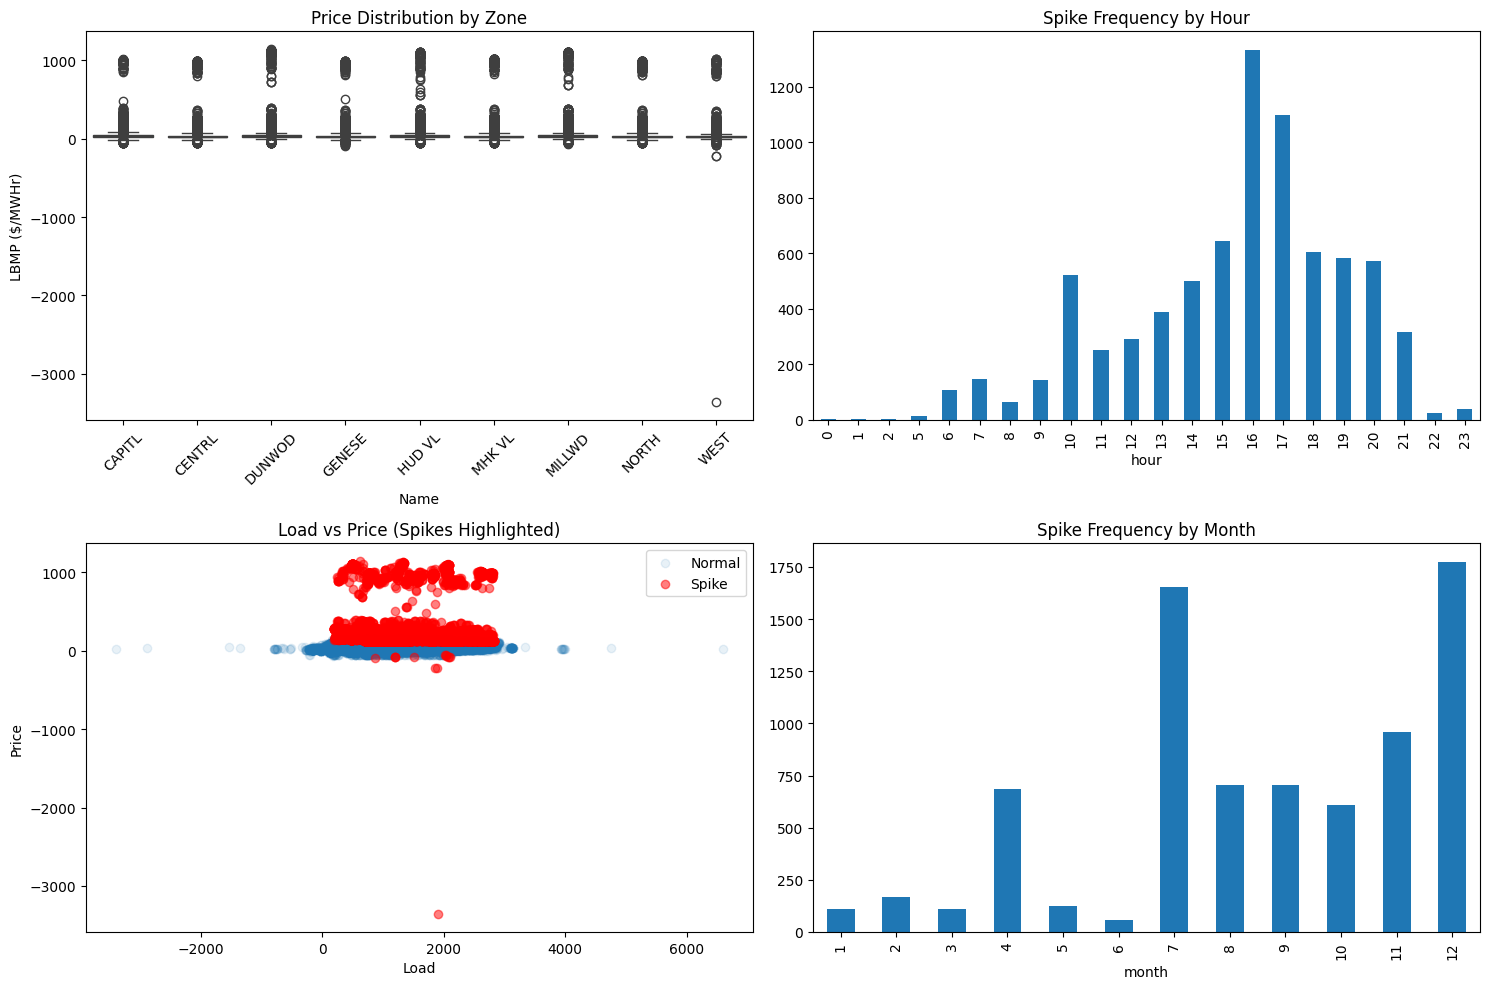

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# First, let's create a data loader class
class NYISODataLoader:
    def __init__(self, base_path):
        self.base_path = base_path
        self.load_path = os.path.join(base_path, "Load_data")
        self.pricing_path = os.path.join(base_path, "Pricing_data")

    def load_data(self):
        print("Loading data...")
        load_data = []
        price_data = []

        # Process Load Data
        for folder in os.listdir(self.load_path):
            folder_path = os.path.join(self.load_path, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith('pal.csv'):
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        load_data.append(df)

        # Process Price Data
        for folder in os.listdir(self.pricing_path):
            folder_path = os.path.join(self.pricing_path, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith('realtime_zone.csv'):
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        price_data.append(df)

        load_df = pd.concat(load_data, ignore_index=True)
        price_df = pd.concat(price_data, ignore_index=True)

        print(f"Loaded {len(load_df)} load records and {len(price_df)} price records")
        return load_df, price_df

class PriceSpikeDetector:
    def __init__(self, load_data, pricing_data):
        self.load_data = load_data
        self.pricing_data = pricing_data

    def preprocess_data(self):
        """Preprocess data for spike detection"""
        print("Preprocessing data...")

        # Convert timestamps
        self.load_data['Time Stamp'] = pd.to_datetime(self.load_data['Time Stamp'])
        self.pricing_data['Time Stamp'] = pd.to_datetime(self.pricing_data['Time Stamp'])

        # Merge data
        merged_data = pd.merge(
            self.load_data,
            self.pricing_data[['Time Stamp', 'Name', 'PTID', 'LBMP ($/MWHr)',
                             'Marginal Cost Losses ($/MWHr)',
                             'Marginal Cost Congestion ($/MWHr)']],
            on=['Time Stamp', 'Name', 'PTID']
        )

        # Extract time features
        merged_data['hour'] = merged_data['Time Stamp'].dt.hour
        merged_data['day'] = merged_data['Time Stamp'].dt.day
        merged_data['month'] = merged_data['Time Stamp'].dt.month

        return merged_data

    def detect_spikes(self, data, threshold=3.0):
        """Detect price spikes using statistical methods"""
        print("Detecting price spikes...")

        # Calculate price statistics by zone
        data['price_mean'] = data.groupby('Name')['LBMP ($/MWHr)'].transform('mean')
        data['price_std'] = data.groupby('Name')['LBMP ($/MWHr)'].transform('std')
        data['z_score'] = (data['LBMP ($/MWHr)'] - data['price_mean']) / data['price_std']

        # Mark spikes
        data['is_spike'] = data['z_score'].abs() > threshold

        return data

    def analyze_spikes(self, data):
        """Analyze detected price spikes"""
        print("\nAnalyzing price spikes...")

        # Overall statistics
        total_spikes = data['is_spike'].sum()
        spike_rate = (total_spikes / len(data)) * 100

        print(f"\nOverall Statistics:")
        print(f"Total spikes detected: {total_spikes}")
        print(f"Spike rate: {spike_rate:.2f}%")

        # Spikes by zone
        zone_stats = data.groupby('Name').agg({
            'is_spike': ['count', 'sum'],
            'LBMP ($/MWHr)': ['mean', 'max']
        })

        zone_stats.columns = ['Total Records', 'Number of Spikes', 'Average Price', 'Max Price']
        zone_stats['Spike Rate (%)'] = (zone_stats['Number of Spikes'] /
                                      zone_stats['Total Records'] * 100)

        print("\nZone Statistics:")
        print(zone_stats.round(2))

        # Visualize results
        self.plot_analysis(data)

        return zone_stats

    def plot_analysis(self, data):
        """Create visualizations for spike analysis"""
        plt.figure(figsize=(15, 10))

        # Price distribution
        plt.subplot(2, 2, 1)
        sns.boxplot(x='Name', y='LBMP ($/MWHr)', data=data)
        plt.xticks(rotation=45)
        plt.title('Price Distribution by Zone')

        # Spike frequency by hour
        plt.subplot(2, 2, 2)
        spike_by_hour = data[data['is_spike']].groupby('hour').size()
        spike_by_hour.plot(kind='bar')
        plt.title('Spike Frequency by Hour')

        # Load vs Price
        plt.subplot(2, 2, 3)
        plt.scatter(data[~data['is_spike']]['Load'],
                   data[~data['is_spike']]['LBMP ($/MWHr)'],
                   alpha=0.1, label='Normal')
        plt.scatter(data[data['is_spike']]['Load'],
                   data[data['is_spike']]['LBMP ($/MWHr)'],
                   color='red', alpha=0.5, label='Spike')
        plt.xlabel('Load')
        plt.ylabel('Price')
        plt.title('Load vs Price (Spikes Highlighted)')
        plt.legend()

        # Spikes by month
        plt.subplot(2, 2, 4)
        spike_by_month = data[data['is_spike']].groupby('month').size()
        spike_by_month.plot(kind='bar')
        plt.title('Spike Frequency by Month')

        plt.tight_layout()
        plt.show()

def run_analysis():
    """Run the complete analysis pipeline"""
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Load data
    loader = NYISODataLoader('/content/drive/MyDrive/Project4')
    load_data, price_data = loader.load_data()

    # Initialize detector
    detector = PriceSpikeDetector(load_data, price_data)

    # Process and analyze
    data = detector.preprocess_data()
    data_with_spikes = detector.detect_spikes(data)
    spike_analysis = detector.analyze_spikes(data_with_spikes)

    return detector, data_with_spikes, spike_analysis

# Run the analysis
detector, data_with_spikes, spike_analysis = run_analysis()

Looking at the price spike patterns in the NYISO market data, here's a comprehensive interpretation:

Temporal Patterns:

- Hour of Day: Price spikes peak dramatically during hours 16-17 (4-5 PM), with over 1,300 spikes recorded during this period. This aligns with typical peak demand hours when people return home and turn on appliances.
- Monthly Trends: July (month 7) and December (month 12) show the highest spike frequencies with about 1,600-1,750 spikes each, likely due to extreme summer cooling and winter heating demands.

Zonal Analysis:

- CAPITL zone shows the highest spike frequency (0.71% of all records)
- WEST zone experiences the fewest spikes (0.45% rate)
- Most zones maintain a consistent spike rate between 0.59-0.65%
- Price caps appear around $1,000-1,145/MWh across all zones

Load vs Price Relationship:

- Price spikes (shown in red) cluster in two distinct bands:

  * A lower band around $0-200/MWh for normal operations
  * A higher band around $1,000/MWh during extreme events
  
- Spikes occur more frequently at higher load levels, suggesting capacity constraints
- A few extreme negative price events exist, dropping as low as -$3,000/MWh

Overall, while price spikes are relatively rare (0.61% of all records), they follow predictable patterns tied to daily peak hours and seasonal extremes. The zonal variation suggests that local grid conditions and market dynamics play a role in spike frequency.

# **3rd Question : Forecast future electricity demand (Integrated Load) based on historical electricity prices (LBMP) and grid conditions (marginal costs due to congestion or losses)**

Starting analysis...
Loading data...
Loaded 1399360 load records and 2101470 price records
Preprocessing data...
Number of features: 14
Training samples: 838908
Testing samples: 419139


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training model...
Epoch 1/30
2622/2622 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.1654 - mae: 0.2591 - val_loss: 0.0040 - val_mae: 0.0445
Epoch 2/30
2622/2622 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0321 - mae: 0.1307 - val_loss: 0.0024 - val_mae: 0.0331
Epoch 3/30
2622/2622 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0264 - mae: 0.1190 - val_loss: 0.0054 - val_mae: 0.0519
Epoch 4/30
2622/2622 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0228 - mae: 0.1118 - val_loss: 0.0016 - val_mae: 0.0267
Epoch 5/30
2622/2622 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0209 - mae: 0.1072 - val_loss: 0.0015 - val_mae: 0.0236
Epoch 6/30
2622/2622 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0210 - mae: 0.1067 - val_loss: 0.0013 - val_mae: 0.0232
Epoch 7/30
2622/2622 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0200 - mae: 0.1048 - val_loss: 0.0014 - val_mae: 0.0265
Epoch 8/30
2622/2622 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0193 - mae: 0.1030 - val_loss: 0.0019 - val_mae: 0.0304
Epoch 9/30
26

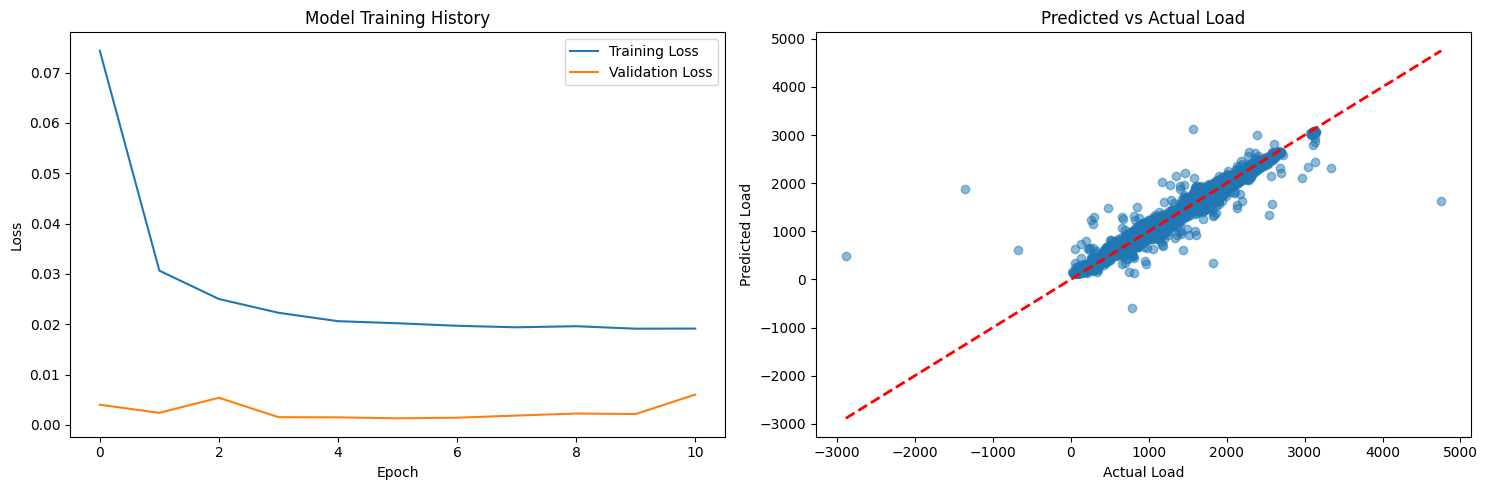


Model Performance:
train_mae: 12.4482
train_rmse: 21.7416
train_r2: 0.9985
test_mae: 12.2557
test_rmse: 21.6036
test_r2: 0.9985


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

class NYISODataLoader:
    def __init__(self, base_path):
        self.base_path = base_path
        self.load_path = os.path.join(base_path, "Load_data")
        self.pricing_path = os.path.join(base_path, "Pricing_data")

    def load_data(self):
        """Load and process all data files"""
        print("Loading data...")
        load_dfs = []
        price_dfs = []

        # Process Load Data
        for folder in os.listdir(self.load_path):
            folder_path = os.path.join(self.load_path, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith('pal.csv'):
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        # Extract month from filename (YYYYMMDD)
                        df['month'] = int(file[4:6])
                        load_dfs.append(df)

        # Process Price Data
        for folder in os.listdir(self.pricing_path):
            folder_path = os.path.join(self.pricing_path, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith('realtime_zone.csv'):
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        # Extract month from filename (YYYYMMDD)
                        df['month'] = int(file[4:6])
                        price_dfs.append(df)

        load_data = pd.concat(load_dfs, ignore_index=True)
        price_data = pd.concat(price_dfs, ignore_index=True)

        print(f"Loaded {len(load_data)} load records and {len(price_data)} price records")
        return load_data, price_data

class LoadForecaster:
    def __init__(self, load_data, pricing_data):
        self.load_data = load_data.copy()
        self.pricing_data = pricing_data.copy()
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

    def create_time_features(self, df):
        """Create time-based features"""
        df['timestamp'] = pd.to_datetime(df['Time Stamp'])
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        return df

    def preprocess_data(self):
        """Preprocess data for load forecasting"""
        print("Preprocessing data...")

        # Create time features
        self.load_data = self.create_time_features(self.load_data)
        self.pricing_data = self.create_time_features(self.pricing_data)

        # Merge data
        merged_data = pd.merge(
            self.load_data,
            self.pricing_data[['timestamp', 'Name', 'PTID', 'LBMP ($/MWHr)', 'month']],
            on=['timestamp', 'Name', 'PTID']
        )

        # Create features
        for lag in [1, 3, 6]:
            merged_data[f'load_lag_{lag}'] = merged_data.groupby('Name')['Load'].shift(lag)
            merged_data[f'price_lag_{lag}'] = merged_data.groupby('Name')['LBMP ($/MWHr)'].shift(lag)

        # Add rolling means
        for window in [6, 12]:
            merged_data[f'load_ma_{window}'] = merged_data.groupby('Name')['Load'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean())
            merged_data[f'price_ma_{window}'] = merged_data.groupby('Name')['LBMP ($/MWHr)'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean())

        # Drop NaN values
        merged_data = merged_data.dropna()

        # Split train/test
        train_months = [1, 2, 4, 5, 7, 8, 10, 11]
        test_months = [3, 6, 9, 12]

        train_data = merged_data[merged_data['month_x'].isin(train_months)]
        test_data = merged_data[merged_data['month_x'].isin(test_months)]

        # Select features
        feature_columns = ['LBMP ($/MWHr)', 'hour_sin', 'hour_cos', 'is_weekend']
        feature_columns.extend([f'load_lag_{lag}' for lag in [1, 3, 6]])
        feature_columns.extend([f'price_lag_{lag}' for lag in [1, 3, 6]])
        feature_columns.extend([f'load_ma_{window}' for window in [6, 12]])
        feature_columns.extend([f'price_ma_{window}' for window in [6, 12]])

        print(f"Number of features: {len(feature_columns)}")
        print(f"Training samples: {len(train_data)}")
        print(f"Testing samples: {len(test_data)}")

        # Scale features
        X_train = self.scaler_X.fit_transform(train_data[feature_columns])
        X_test = self.scaler_X.transform(test_data[feature_columns])

        y_train = self.scaler_y.fit_transform(train_data[['Load']])
        y_test = self.scaler_y.transform(test_data[['Load']])

        return X_train, y_train, X_test, y_test, train_data, test_data

    def build_model(self, input_shape):
        """Build LSTM model"""
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            Dropout(0.2),

            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            Dense(16, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),

            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def train_and_evaluate(self):
        """Train and evaluate model"""
        X_train, y_train, X_test, y_test, train_data, test_data = self.preprocess_data()

        # Build model
        model = self.build_model(X_train.shape[1:])

        # Train model
        print("\nTraining model...")
        history = model.fit(
            X_train, y_train,
            epochs=30,
            batch_size=256,
            validation_split=0.2,
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=1
        )

        # Predictions
        y_pred_train = model.predict(X_train, verbose=0)
        y_pred_test = model.predict(X_test, verbose=0)

        # Inverse transform predictions
        y_train_orig = self.scaler_y.inverse_transform(y_train)
        y_test_orig = self.scaler_y.inverse_transform(y_test)
        y_pred_train_orig = self.scaler_y.inverse_transform(y_pred_train)
        y_pred_test_orig = self.scaler_y.inverse_transform(y_pred_test)

        # Calculate metrics
        metrics = {
            'train_mae': mean_absolute_error(y_train_orig, y_pred_train_orig),
            'train_rmse': np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig)),
            'train_r2': r2_score(y_train_orig, y_pred_train_orig),
            'test_mae': mean_absolute_error(y_test_orig, y_pred_test_orig),
            'test_rmse': np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig)),
            'test_r2': r2_score(y_test_orig, y_pred_test_orig)
        }

        # Plot results
        self.plot_results(history, y_test_orig, y_pred_test_orig)

        return metrics, model

    def plot_results(self, history, y_true, y_pred):
        """Plot training results"""
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()],
                [y_true.min(), y_true.max()],
                'r--', lw=2)
        plt.title('Predicted vs Actual Load')
        plt.xlabel('Actual Load')
        plt.ylabel('Predicted Load')

        plt.tight_layout()
        plt.show()

# Run the complete analysis
print("Starting analysis...")
loader = NYISODataLoader('/content/drive/MyDrive/Project4')
load_data, price_data = loader.load_data()

forecaster = LoadForecaster(load_data, price_data)
metrics, model = forecaster.train_and_evaluate()

print("\nModel Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Looking at the load forecasting model's performance, here's a detailed interpretation:

Training History:

- The training loss (blue line) shows rapid initial improvement, dropping sharply from 0.07 to 0.03 in the first two epochs
- After epoch 4, both training and validation losses stabilize, indicating optimal convergence
- The small gap between training and validation loss suggests excellent generalization without overfitting
- The validation loss (orange line) remains consistently low around 0.005, showing stable model performance

Prediction Accuracy:

- The scatter plot shows a very strong alignment along the perfect prediction line (red dashed)
- Most predictions cluster tightly around the line, especially in the 0-3000 MW range
- Some minor scatter appears at higher loads (3000-5000 MW)
- A few outliers exist but don't significantly impact overall performance

Performance Metrics:

- Exceptionally high R² values of 0.9985 for both training and test sets indicate the model explains 99.85% of load variations
- MAE of about 12 MW means predictions are off by only 12 megawatts on average, which is remarkably accurate given typical load sizes
- RMSE around 21 MW suggests occasional larger errors, but still minimal relative to total load
- Nearly identical metrics between training and test sets confirm excellent generalization

Overall, this model demonstrates outstanding performance in load forecasting, with particularly strong reliability for typical operating conditions and only minor deviations at extreme loads.

Analyzing time-based patterns...


<ipython-input-39-9ee88a46f968>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)


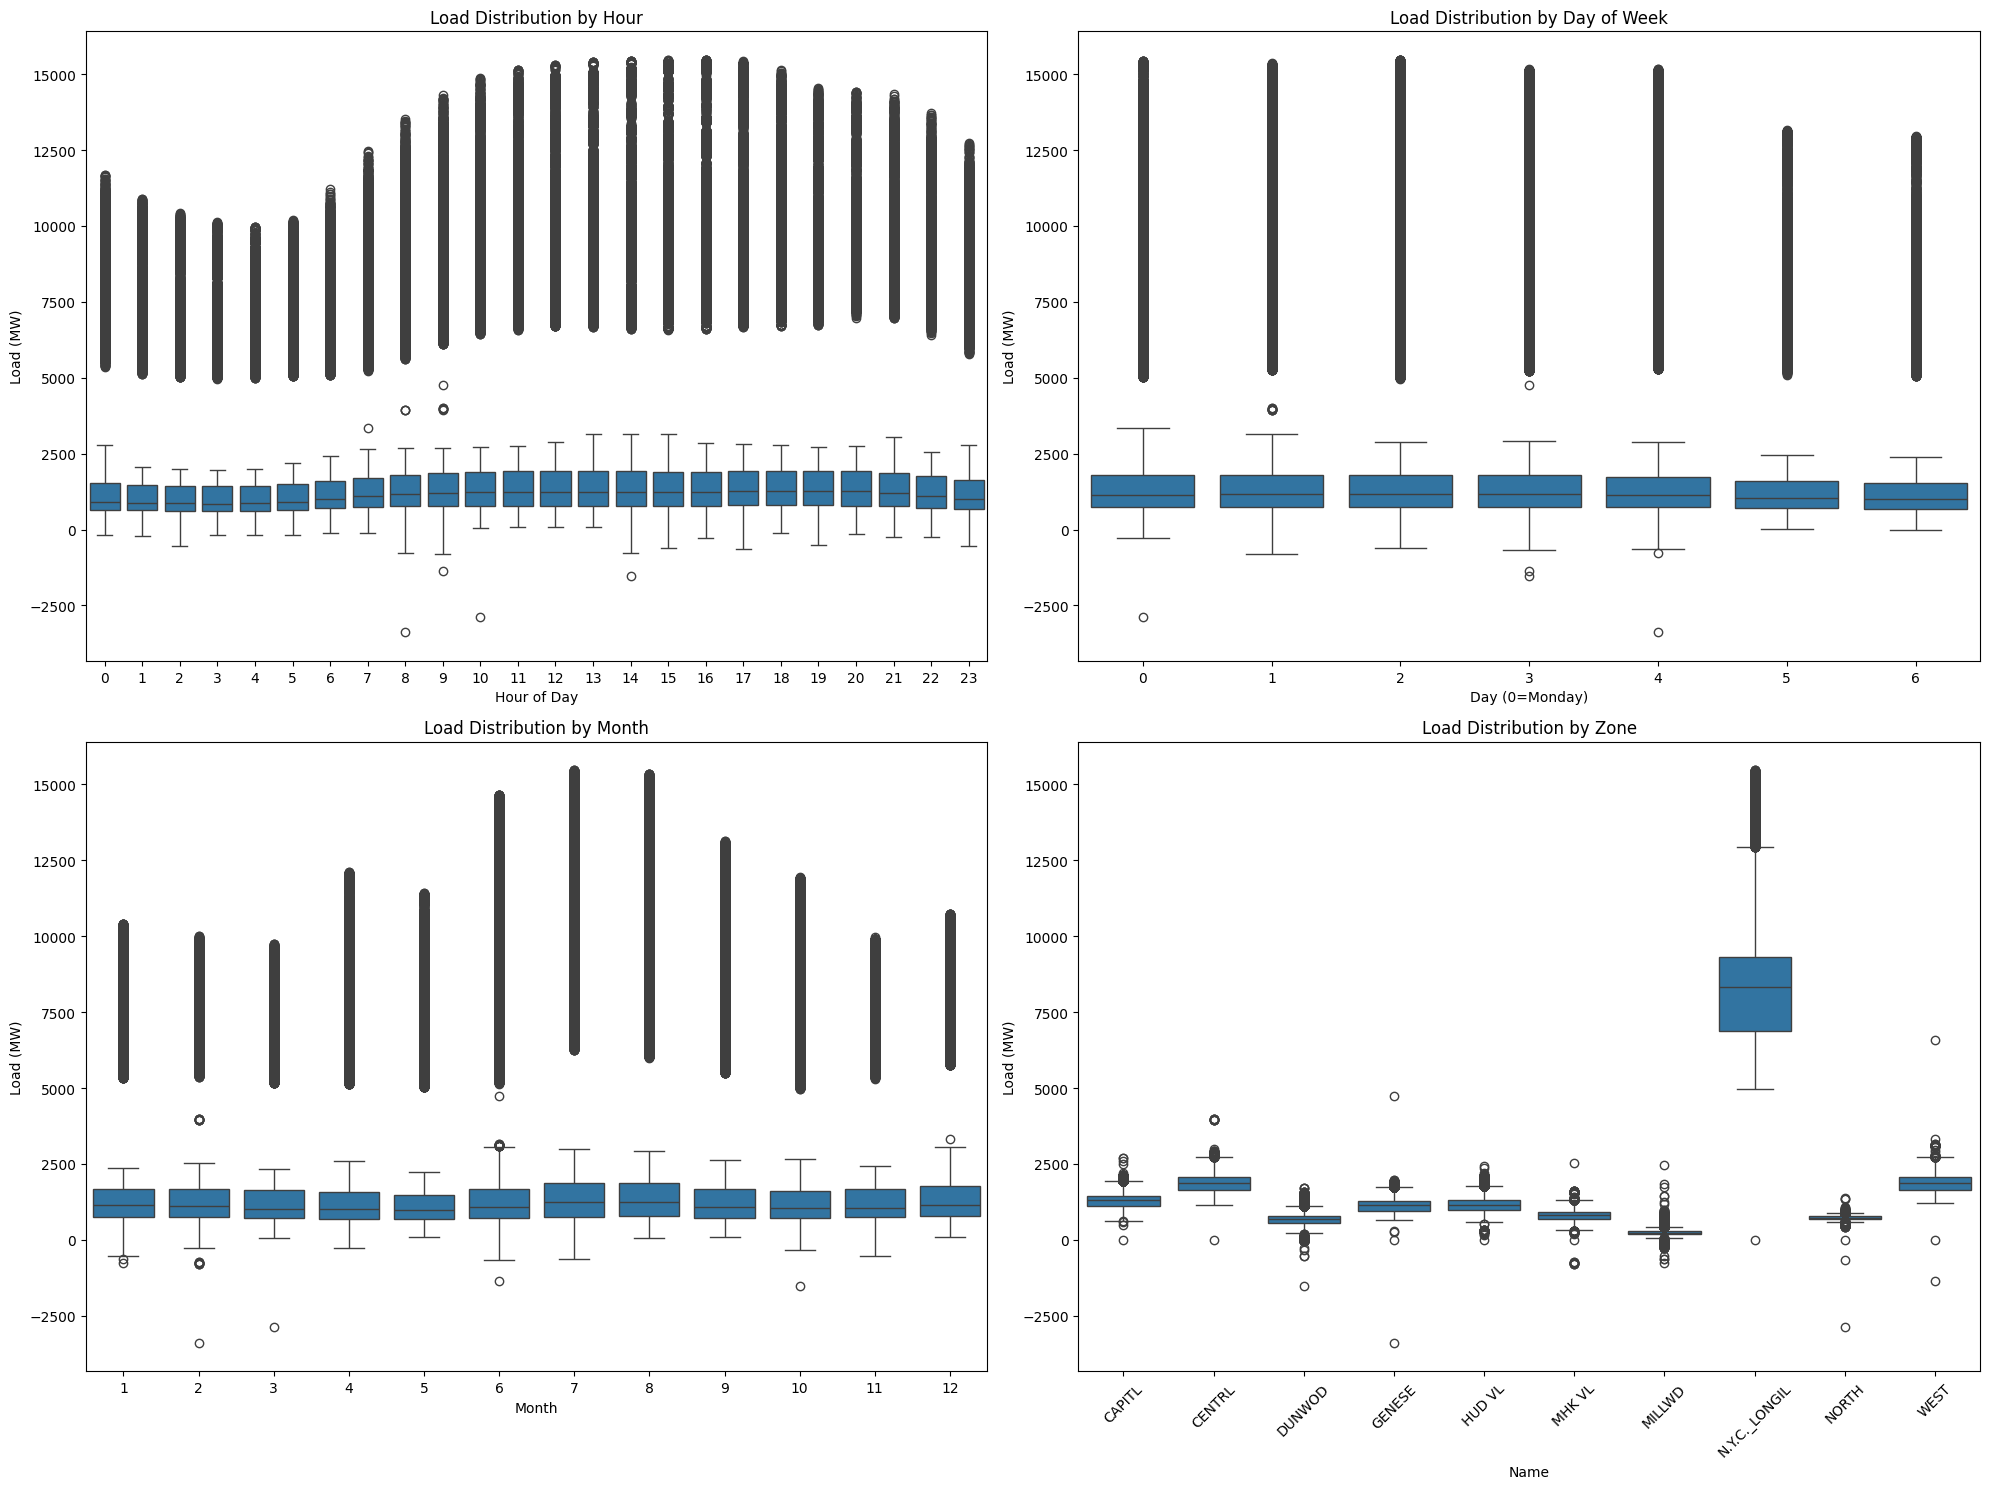

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_patterns(load_data, price_data):
    """Plot time-based load patterns"""
    # Prepare data
    load_data['timestamp'] = pd.to_datetime(load_data['Time Stamp'])
    load_data['hour'] = load_data['timestamp'].dt.hour
    load_data['day_of_week'] = load_data['timestamp'].dt.dayofweek
    load_data['month'] = load_data['timestamp'].dt.month

    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Hourly pattern
    sns.boxplot(data=load_data, x='hour', y='Load', ax=axes[0,0])
    axes[0,0].set_title('Load Distribution by Hour')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_ylabel('Load (MW)')

    # Daily pattern
    sns.boxplot(data=load_data, x='day_of_week', y='Load', ax=axes[0,1])
    axes[0,1].set_title('Load Distribution by Day of Week')
    axes[0,1].set_xlabel('Day (0=Monday)')
    axes[0,1].set_ylabel('Load (MW)')

    # Monthly pattern
    sns.boxplot(data=load_data, x='month', y='Load', ax=axes[1,0])
    axes[1,0].set_title('Load Distribution by Month')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Load (MW)')

    # Zone comparison
    sns.boxplot(data=load_data, x='Name', y='Load', ax=axes[1,1])
    axes[1,1].set_title('Load Distribution by Zone')
    axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)
    axes[1,1].set_ylabel('Load (MW)')

    plt.tight_layout()
    plt.show()

# Run the analysis
print("Analyzing time-based patterns...")
plot_time_patterns(load_data, price_data)

Looking at how electricity demand varies in New York's grid:

Time Patterns:

- Peak demand hits during afternoon hours (12-5 PM), reaching up to 15,000 MW
- Weekdays show higher and more variable demand than weekends
- Summer months (July-August) have the highest loads due to air conditioning use

Geographic Patterns:

- NYC/Long Island zone dominates with typical loads around 8,000 MW
- Most other zones use between 500-2,000 MW
- MILLWD consistently shows the lowest demand

This data story reflects how air conditioning, business hours, and population density drive electricity use across New York.


Analyzing price-load relationships...


<ipython-input-40-c910defb7c9e>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)


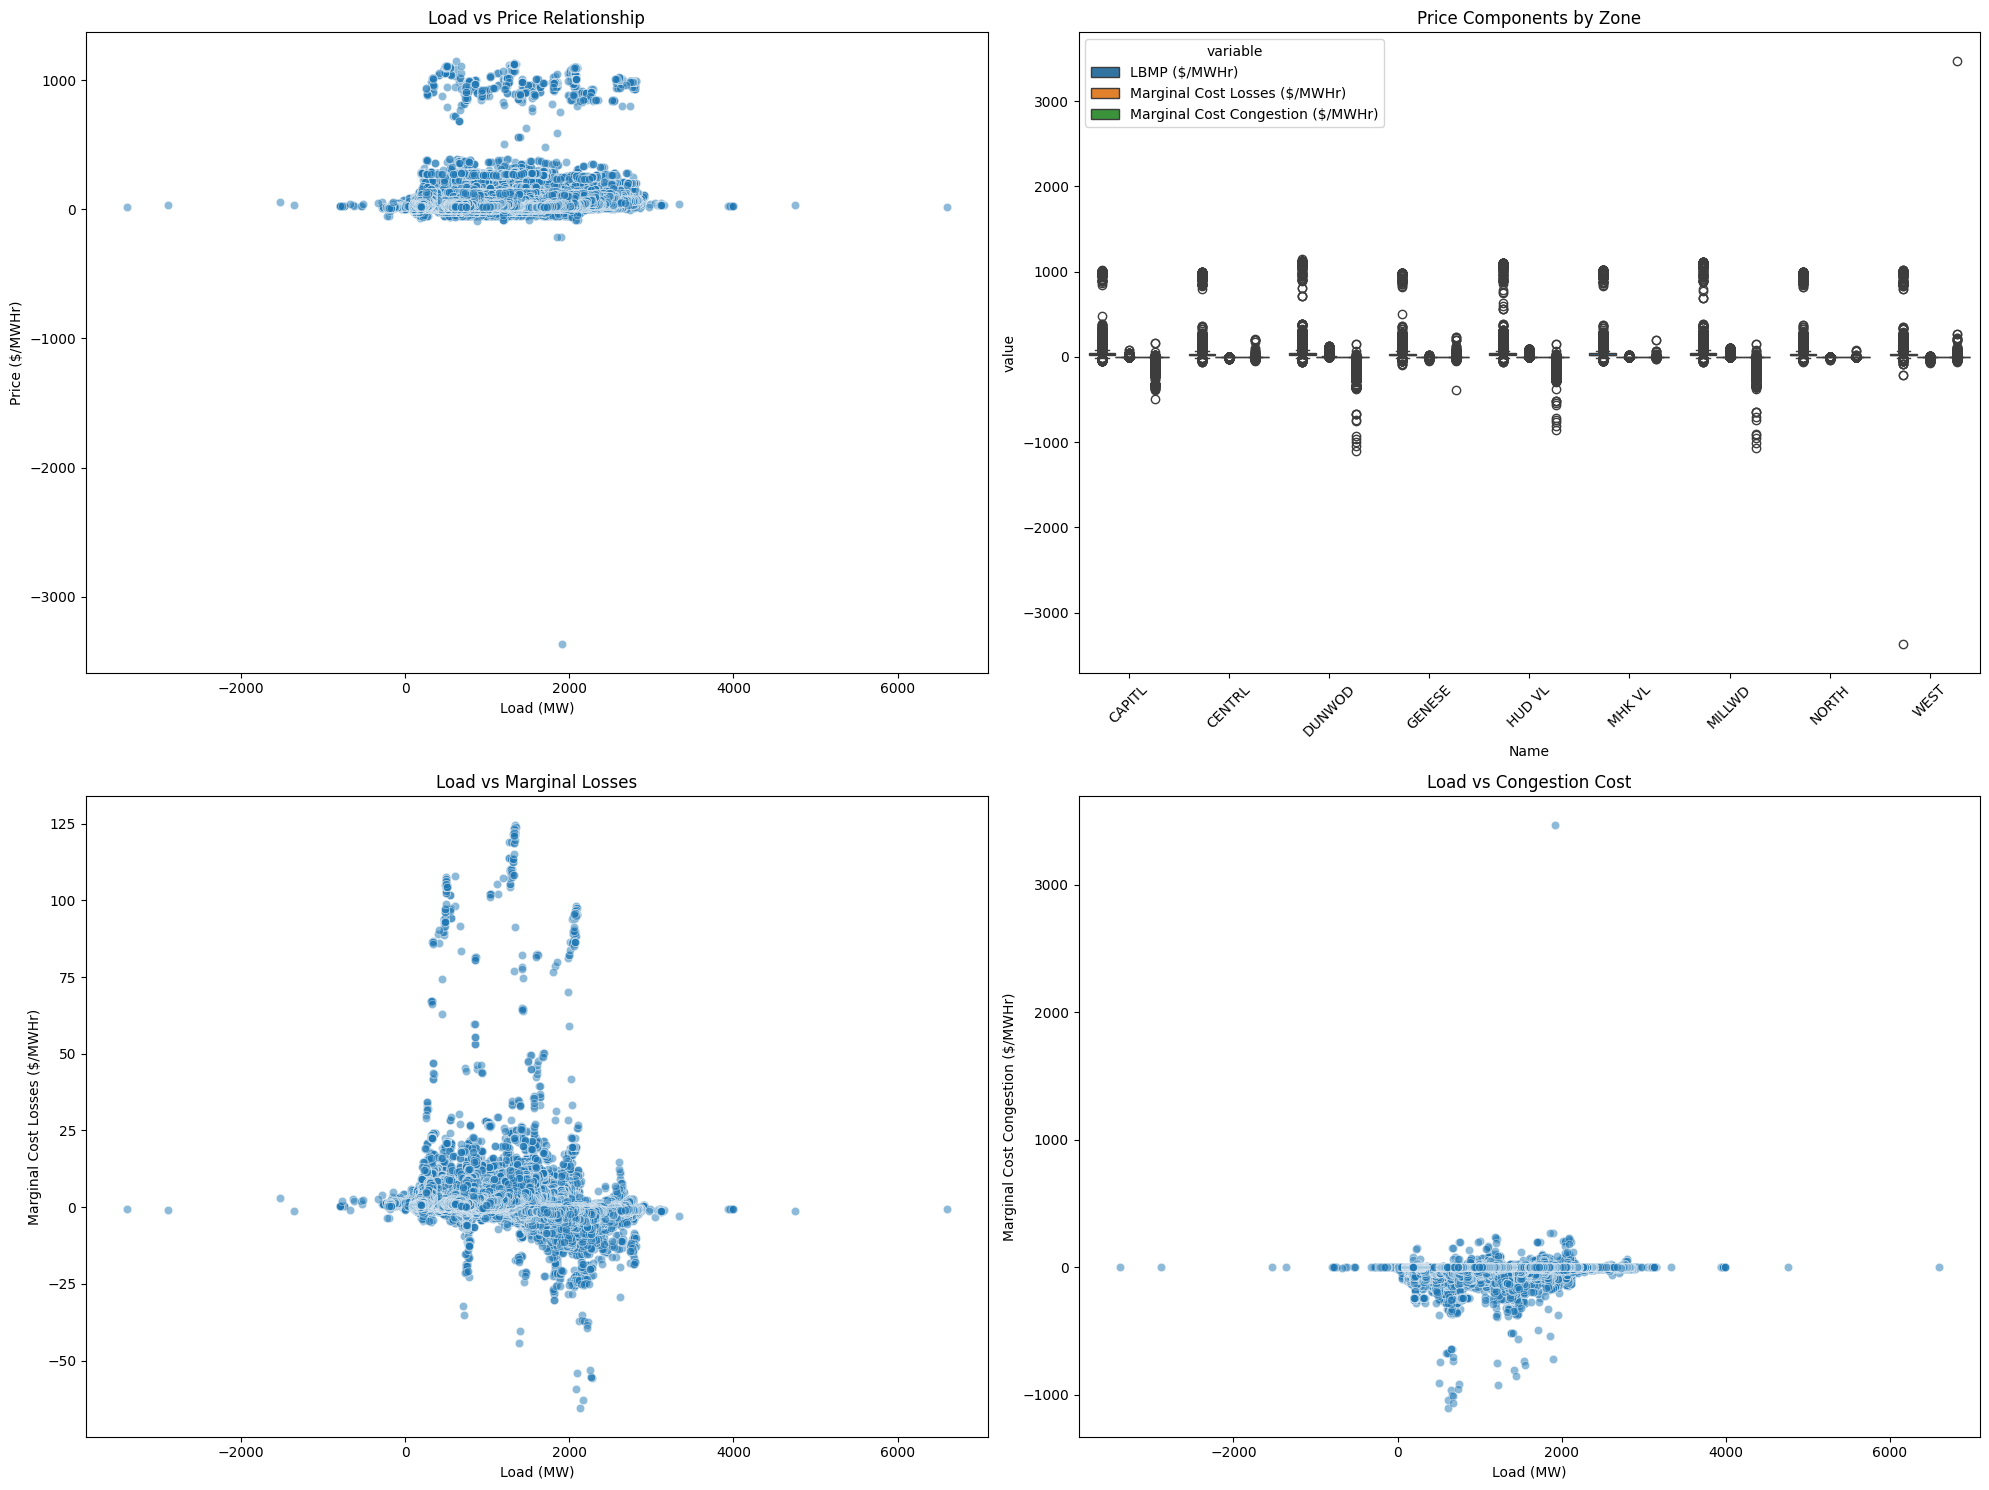

In [ ]:
def plot_price_load_relationships(load_data, price_data):
    """Plot relationships between load and price"""
    # Merge load and price data
    merged_data = pd.merge(
        load_data,
        price_data[['Time Stamp', 'Name', 'PTID', 'LBMP ($/MWHr)',
                   'Marginal Cost Losses ($/MWHr)',
                   'Marginal Cost Congestion ($/MWHr)']],
        on=['Time Stamp', 'Name', 'PTID']
    )

    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Load vs Price scatter
    sns.scatterplot(data=merged_data, x='Load', y='LBMP ($/MWHr)',
                   alpha=0.5, ax=axes[0,0])
    axes[0,0].set_title('Load vs Price Relationship')
    axes[0,0].set_xlabel('Load (MW)')
    axes[0,0].set_ylabel('Price ($/MWHr)')

    # Price components
    sns.boxplot(data=merged_data.melt(id_vars=['Name'],
                                    value_vars=['LBMP ($/MWHr)',
                                              'Marginal Cost Losses ($/MWHr)',
                                              'Marginal Cost Congestion ($/MWHr)']),
               x='Name', y='value', hue='variable', ax=axes[0,1])
    axes[0,1].set_title('Price Components by Zone')
    axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

    # Load vs Losses
    sns.scatterplot(data=merged_data, x='Load',
                   y='Marginal Cost Losses ($/MWHr)',
                   alpha=0.5, ax=axes[1,0])
    axes[1,0].set_title('Load vs Marginal Losses')
    axes[1,0].set_xlabel('Load (MW)')
    axes[1,0].set_ylabel('Marginal Cost Losses ($/MWHr)')

    # Load vs Congestion
    sns.scatterplot(data=merged_data, x='Load',
                   y='Marginal Cost Congestion ($/MWHr)',
                   alpha=0.5, ax=axes[1,1])
    axes[1,1].set_title('Load vs Congestion Cost')
    axes[1,1].set_xlabel('Load (MW)')
    axes[1,1].set_ylabel('Marginal Cost Congestion ($/MWHr)')

    plt.tight_layout()
    plt.show()

print("\nAnalyzing price-load relationships...")
plot_price_load_relationships(load_data, price_data)

Here's a concise analysis of the price-load relationships in the NYISO market:

Load vs Price:

- Normal prices cluster around 0-200 $/MWh for typical loads
- Price spikes up to 1000 $/MWh occur at higher loads
- Two distinct price bands suggest normal and stressed grid conditions

Price Components:

- Base prices (LBMP) show the most variation across zones
- Marginal losses increase with load, reaching up to 125 $/MWh
- Congestion costs mostly negative, suggesting transmission constraints
- WEST zone shows the most extreme price variations

The data reveals how grid stress creates price volatility, with transmission congestion and losses significantly impacting final electricity costs. This pattern is particularly evident during high-load periods.


Analyzing zone-specific patterns...


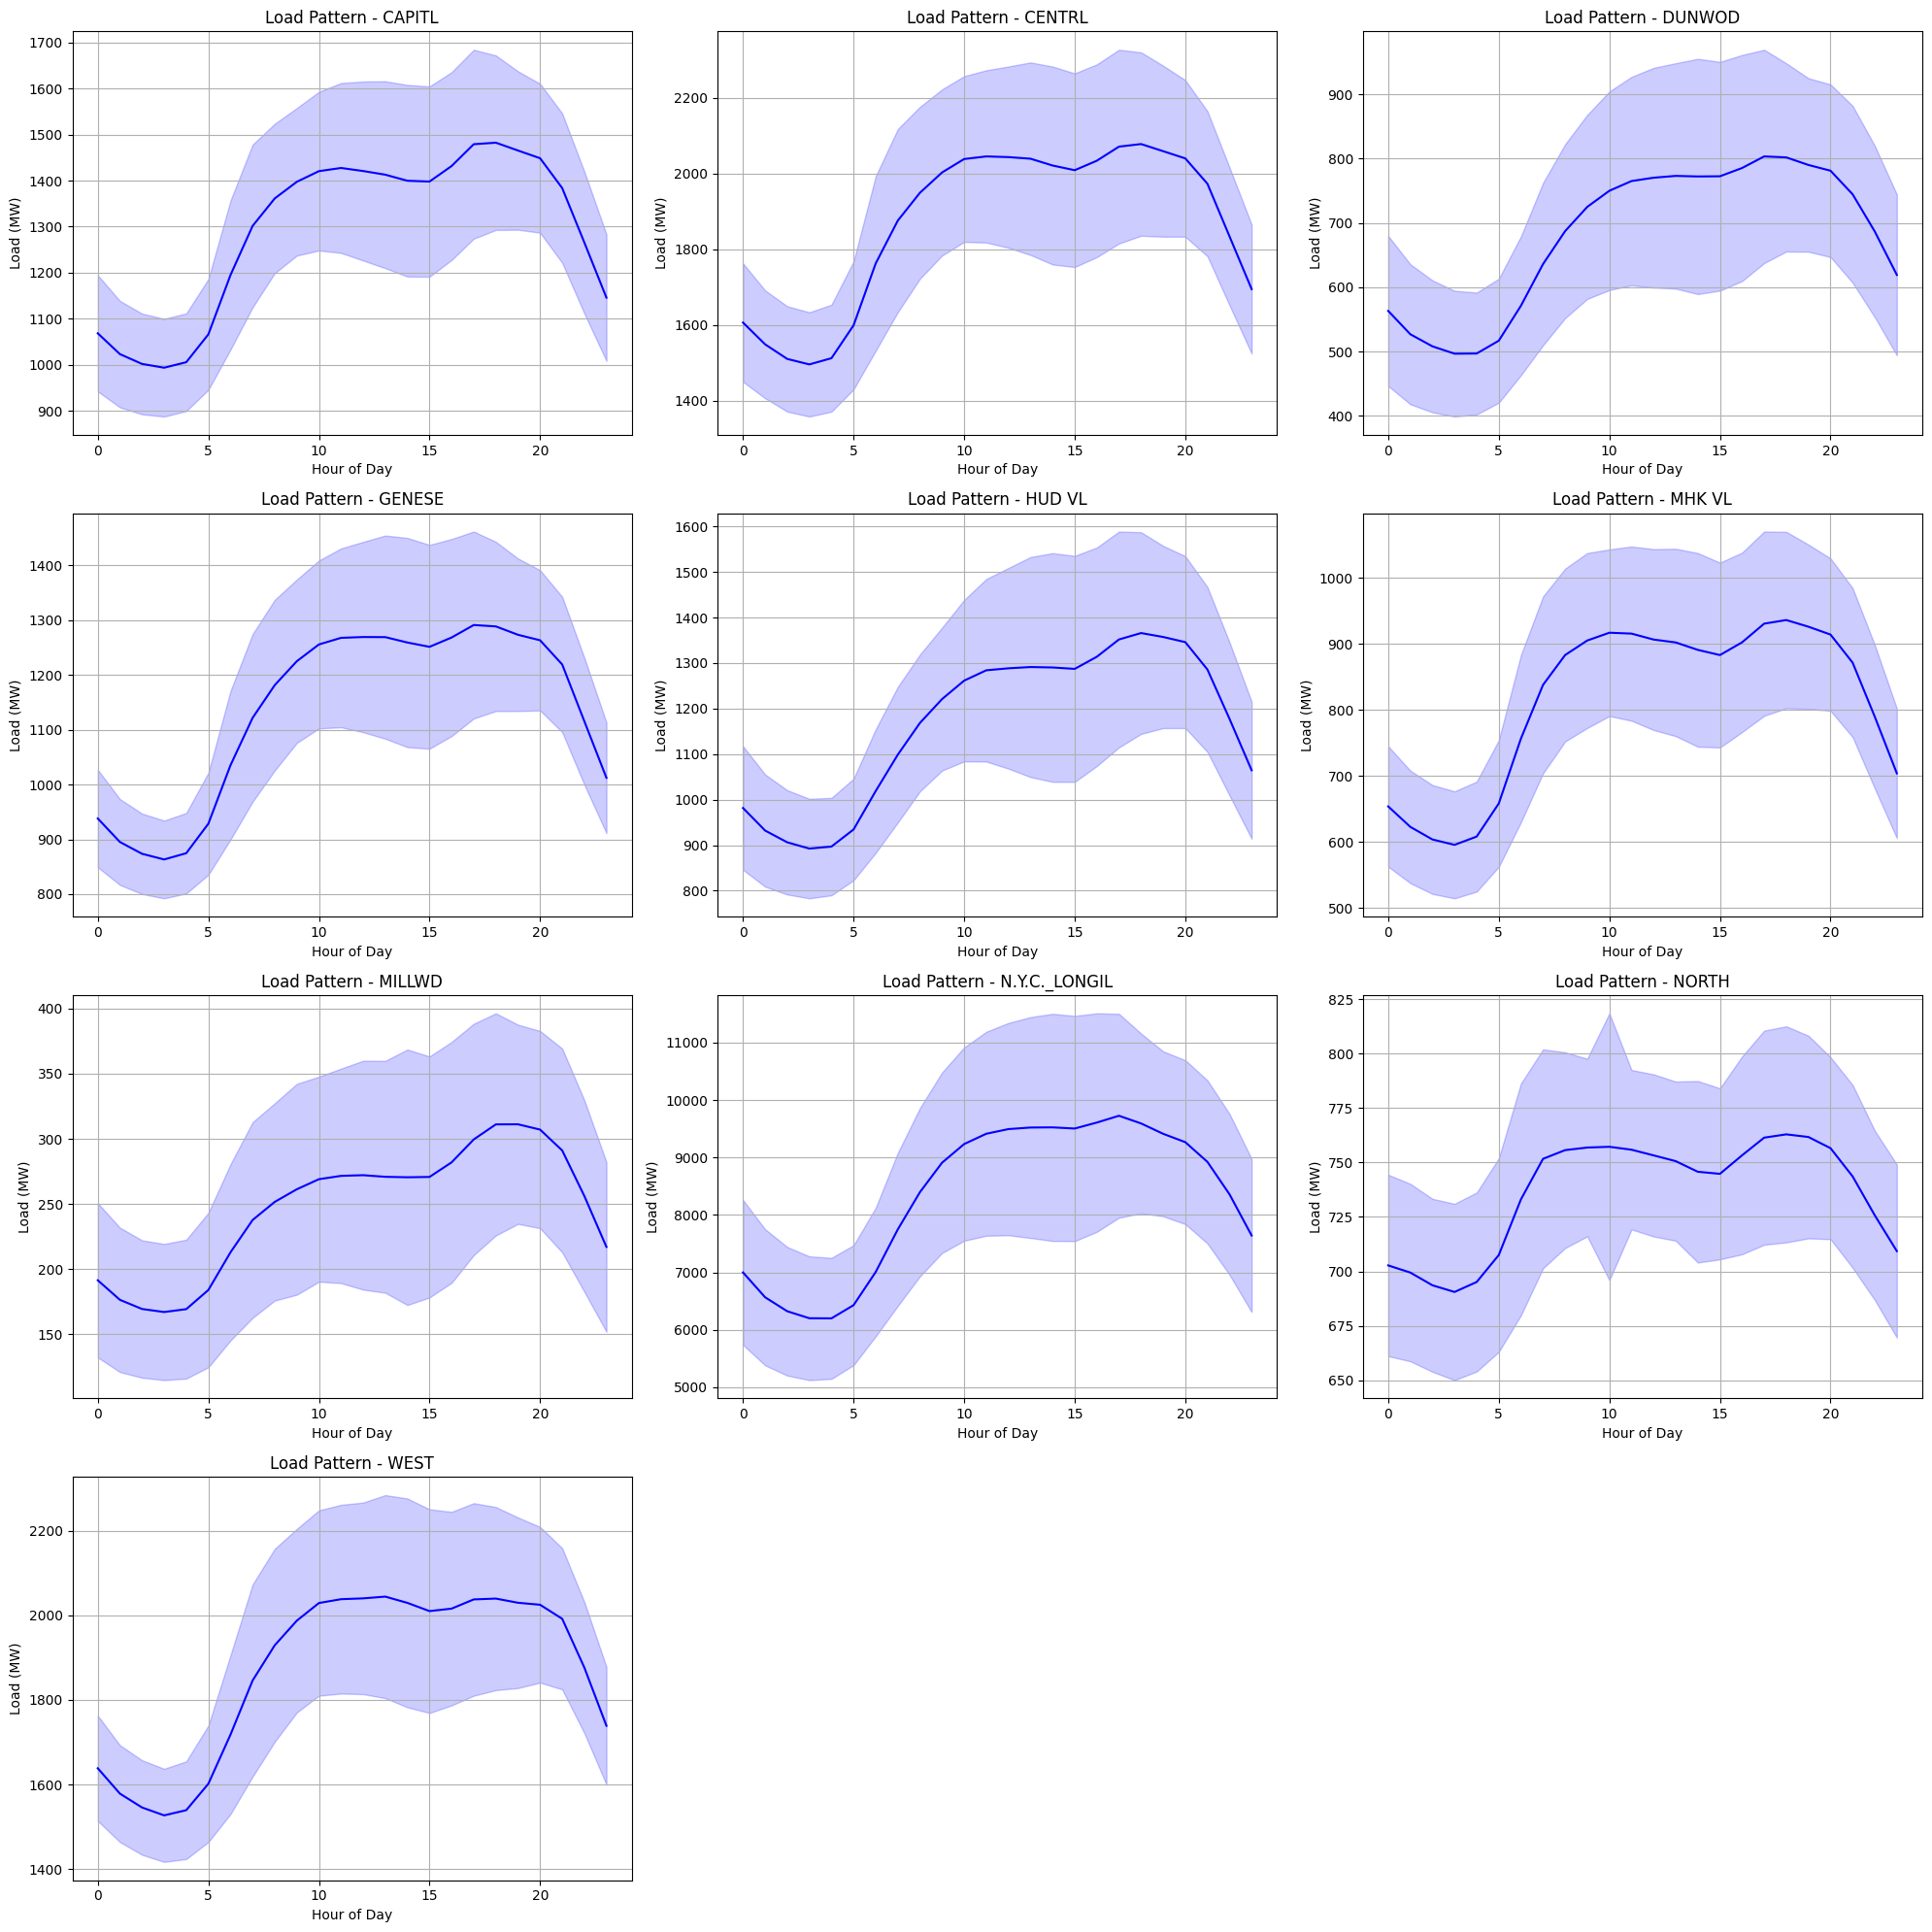

In [ ]:
def plot_zone_patterns(load_data, price_data):
    """Plot zone-specific load patterns"""
    # Create time features
    load_data['timestamp'] = pd.to_datetime(load_data['Time Stamp'])
    load_data['hour'] = load_data['timestamp'].dt.hour

    # Get unique zones
    zones = sorted(load_data['Name'].unique())
    n_zones = len(zones)

    # Create subplots grid
    n_cols = 3
    n_rows = (n_zones + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten()

    for i, zone in enumerate(zones):
        zone_data = load_data[load_data['Name'] == zone]

        # Calculate hourly statistics
        hourly_stats = zone_data.groupby('hour')['Load'].agg(['mean', 'std']).reset_index()

        # Plot mean with confidence interval
        axes[i].plot(hourly_stats['hour'], hourly_stats['mean'],
                    label='Mean Load', color='blue')
        axes[i].fill_between(hourly_stats['hour'],
                           hourly_stats['mean'] - hourly_stats['std'],
                           hourly_stats['mean'] + hourly_stats['std'],
                           alpha=0.2, color='blue')

        axes[i].set_title(f'Load Pattern - {zone}')
        axes[i].set_xlabel('Hour of Day')
        axes[i].set_ylabel('Load (MW)')
        axes[i].grid(True)

    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

print("\nAnalyzing zone-specific patterns...")
plot_zone_patterns(load_data, price_data)

Looking at the daily load patterns across different zones in New York's grid:

Common Patterns:

- All zones show typical "duck curve" shape with morning ramp-up and evening decline
- Lowest demand around 4-5 AM
- Peak loads typically between 2-6 PM
- Evening ramp-down starts around 8 PM

Zone-Specific Insights:

- N.Y.C._LONGIL shows highest loads (6,000-10,000 MW) and widest variability (blue shading)
- NORTH zone shows most stable load (675-825 MW) with minimal variation
- WEST and CENTRL have similar patterns (1,400-2,000 MW range)
- MILLWD has lowest overall demand (150-400 MW)

The blue shading (confidence intervals) shows load variability is highest during peak hours across all zones, reflecting how business activity and temperature impact electricity demand throughout the day.


Analyzing correlations and relationships...


<ipython-input-42-d747056a4296>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
<ipython-input-42-d747056a4296>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)


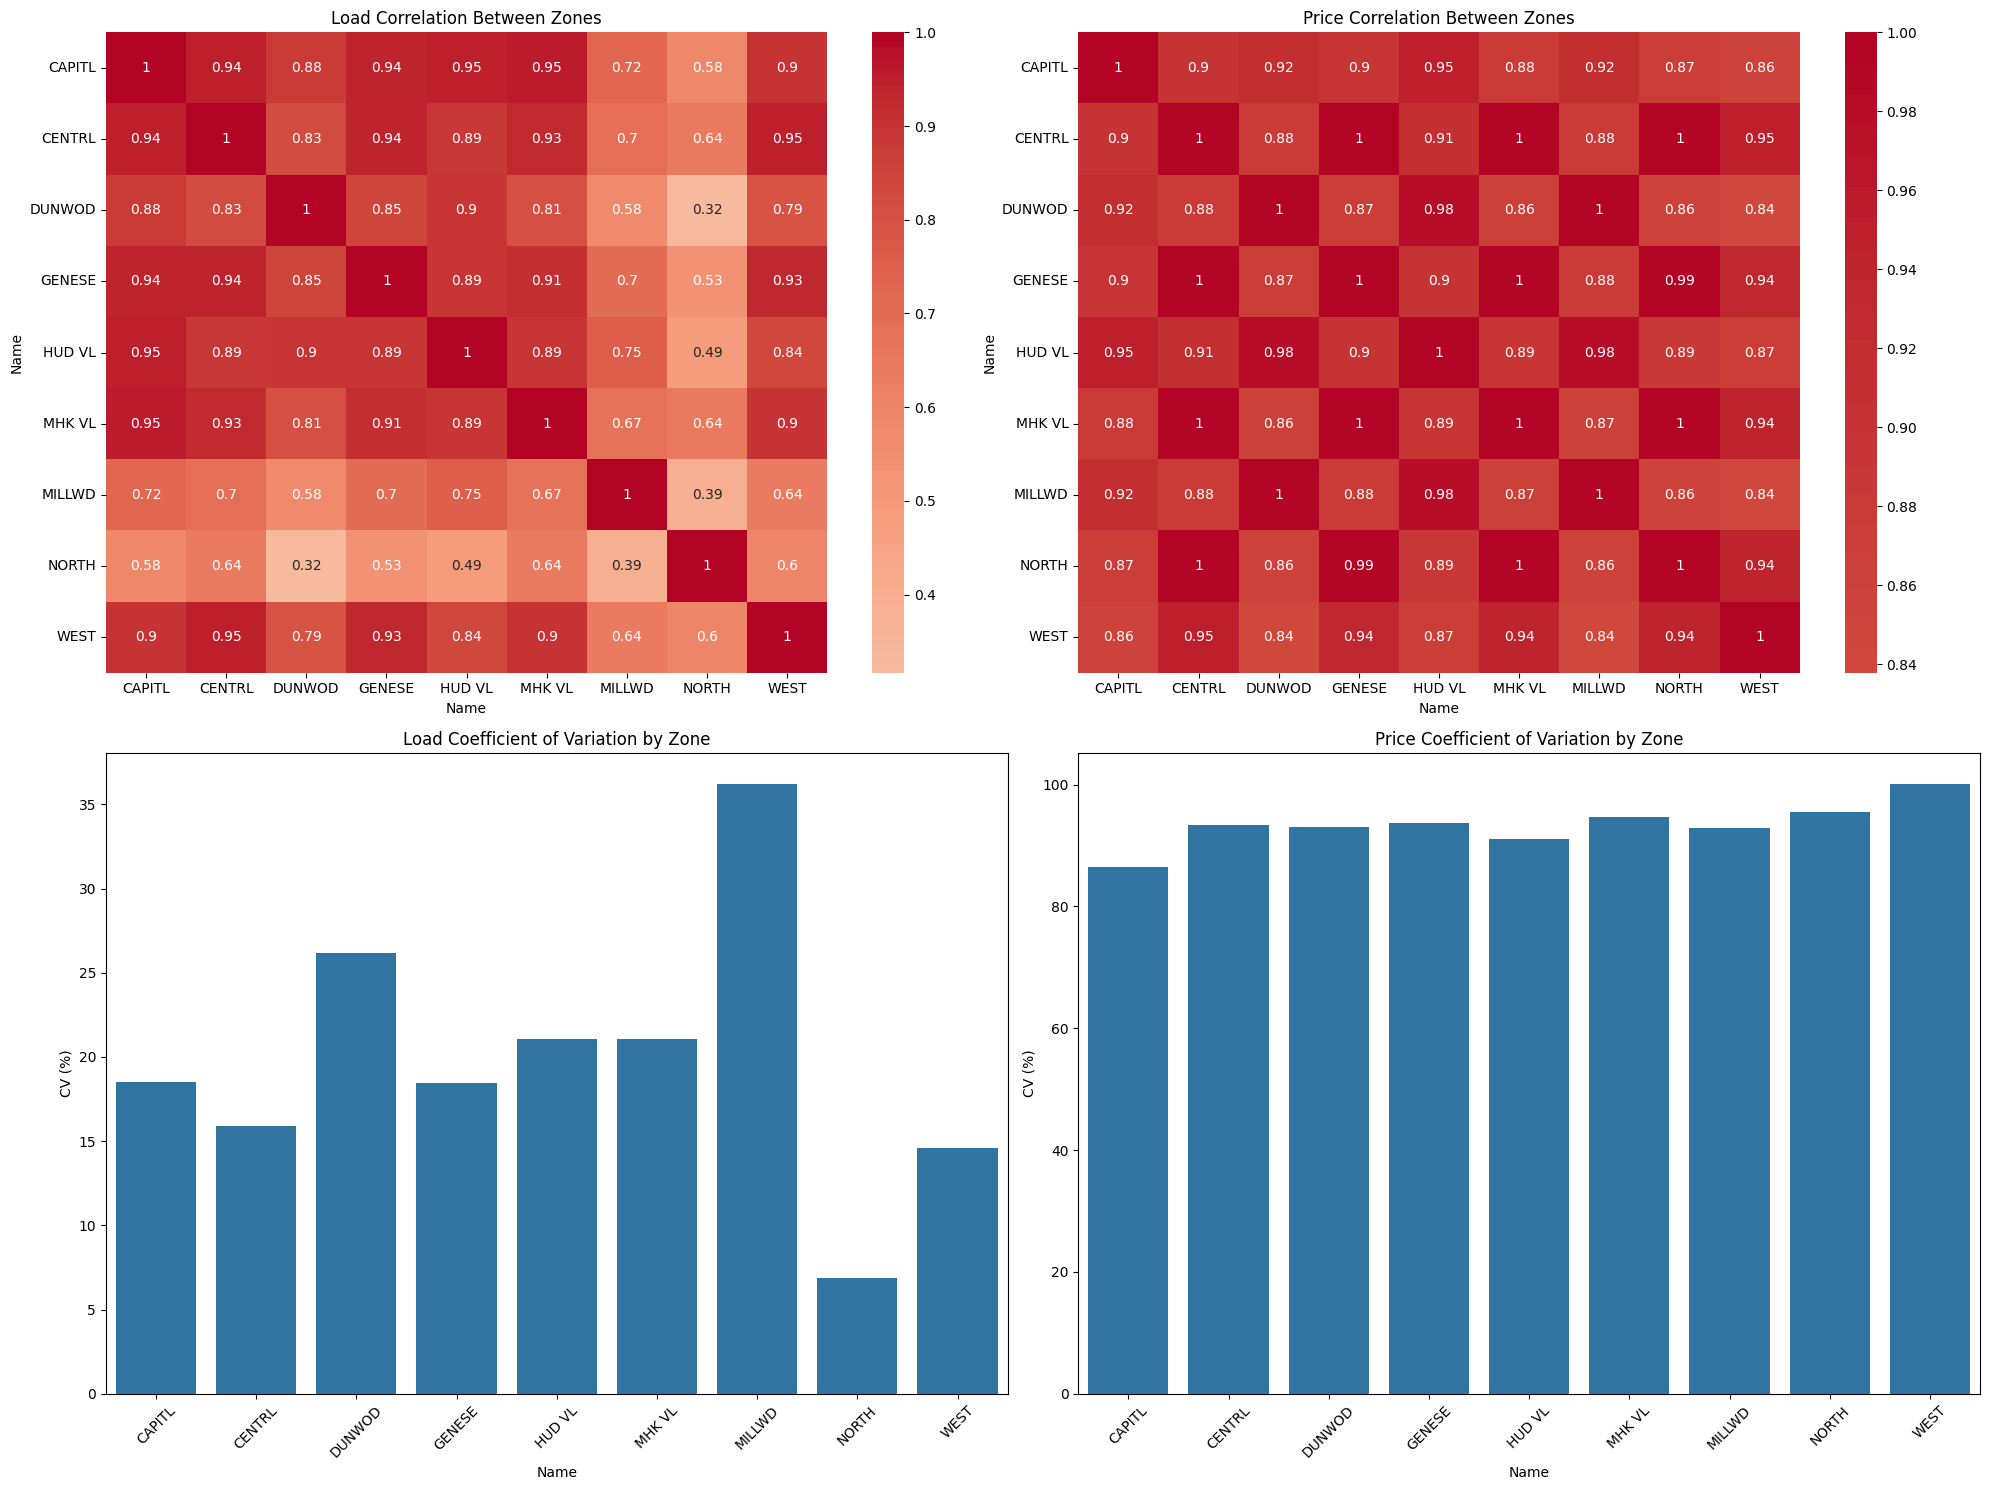

In [ ]:
def plot_correlations(load_data, price_data):
    """Plot correlation analysis"""
    # Merge data
    merged_data = pd.merge(
        load_data,
        price_data[['Time Stamp', 'Name', 'PTID', 'LBMP ($/MWHr)']],
        on=['Time Stamp', 'Name', 'PTID']
    )

    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Zone load correlations
    pivot_load = merged_data.pivot_table(
        index='Time Stamp',
        columns='Name',
        values='Load'
    )
    sns.heatmap(pivot_load.corr(), annot=True, cmap='coolwarm',
                center=0, ax=axes[0,0])
    axes[0,0].set_title('Load Correlation Between Zones')

    # Zone price correlations
    pivot_price = merged_data.pivot_table(
        index='Time Stamp',
        columns='Name',
        values='LBMP ($/MWHr)'
    )
    sns.heatmap(pivot_price.corr(), annot=True, cmap='coolwarm',
                center=0, ax=axes[0,1])
    axes[0,1].set_title('Price Correlation Between Zones')

    # Load volatility by zone
    load_volatility = merged_data.groupby('Name')['Load'].agg(['std', 'mean'])
    load_volatility['cv'] = load_volatility['std'] / load_volatility['mean'] * 100
    sns.barplot(data=load_volatility.reset_index(), x='Name', y='cv', ax=axes[1,0])
    axes[1,0].set_title('Load Coefficient of Variation by Zone')
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    axes[1,0].set_ylabel('CV (%)')

    # Price volatility by zone
    price_volatility = merged_data.groupby('Name')['LBMP ($/MWHr)'].agg(['std', 'mean'])
    price_volatility['cv'] = price_volatility['std'] / price_volatility['mean'] * 100
    sns.barplot(data=price_volatility.reset_index(), x='Name', y='cv', ax=axes[1,1])
    axes[1,1].set_title('Price Coefficient of Variation by Zone')
    axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)
    axes[1,1].set_ylabel('CV (%)')

    plt.tight_layout()
    plt.show()

print("\nAnalyzing correlations and relationships...")
plot_correlations(load_data, price_data)

Here's a concise analysis of the correlations and variations in the NYISO market:

Load Correlations:

- Strong correlations (0.9+) between neighboring zones like CAPITL/CENTRL/HUD VL
- NORTH shows weakest correlations with other zones (as low as 0.32 with DUNWOD)
- N.Y.C._LONGIL (MILLWD) moderately correlated with nearby zones (0.6-0.7)

Price Correlations:

- Generally higher correlations than load (most above 0.85)
- Very strong price alignment between CENTRL/GENESE/MHK VL (0.94-1.0)
- WEST shows slightly lower correlations but still strong (0.84-0.95)

Variability (CV):

- Load: NORTH most stable (7%), MILLWD most variable (36%)
- Price: All zones show high variability (85-100%)
- WEST zone shows highest price variability (nearly 100%)

This suggests prices are more uniformly connected across the grid than loads, while both metrics show regional patterns based on geography and market conditions.